# <font color='blue'> Table Of Contents </font>

### <font color='blue'> Session Roadmap </font>

### <font color='blue'> Deploying The Healthcare Service Backend Using AWS CodePipeline </font>

# <font color='blue'> Session Roadmap </font>

In this mentoring session, the overall goal is to deploy the **Healthcare Service application backend**, on a single **EC2 instance**. We intend to do this using an **AWS CodePipeline** setup, which has the following stages:

* **CodeCommit**
* **CodeBuild**
* **CodeDeploy**

To achieve this, we need to follow these steps:

* Create the Healthcare Service backend codebase **zip** archive
* Create an **EC2 instance**
* Create a **CodeCommit repository**
* **Push** the application codebase to the **CodeCommit** repository
* Create a **CodeBuild Build Project**, and run a **Build** sourced from the **CodeCommit** repository
* Store the generated **Build Artifact** in an **S3 bucket**
* Create a **CodeDeploy Application** to source the **artifact revision** from the **S3 bucket**
* Create a **CodeDeploy Deployment Group** configured to deploy artifacts to the **EC2 instance**
* Install a **CodeDeploy Agent** on the target **EC2 instance**
* Create a **CodeDeploy Deployment** to retrieve the **artifact revision** from the **S3 bucket**, and deploy it as per the **Deployment Group**
* Access the **running application** after this setup
* **Link** these stages to create a **CodePipeline**, triggered by a push to the **CodeCommit** repository, ending with deploying the **artifact revision** 
* Access the **running application** after the **CodePipeline** setup

# <font color='blue'> Deploying The Healthcare Service Backend Using AWS CodePipeline </font>

Let us now start with the above steps, one by one.

# <font color='blue'> Application Backend: Healthcare Service </font>

The Python source code for the Healthcare Backend was shared with all of you as part of the Week 04 Mentor Session material, an a code walkthorugh was provided at that point. The codebase has been shared with you for this session as well. 

The sources are present in the ```service``` folder, with:

* ```HealthcareService.py```: The Python source code
* ```requirements.txt```: the configuration for installing build dependencies (Chiefly the Flask modules)

The **Healthcare Service** reads healthcare device data populated in a **DynamoDB database**, and serves it to web clients through a RESTful API. In this session, we will short-cut the front-end interface and draw data directly from the backend.

We have enhanced this codebase with a ```scripts``` folder, containing bash shell scripts needed for deployment with CodeDeploy. These are elaborated upon, a little later.

We want to deploy this codebase to a single EC2 instance running a Ubuntu AMI.

# <font color='blue'> Setting Up The DynamoDB Database </font>

We can start with setting up a **DynamoDB Database table**. Search for the AWS DynamoDB Service, and on the resulting page, click on ```Create Table```. enter the **Table Name**, **Partition Key**, and **Sort Key** as appropriate for the incoming data:

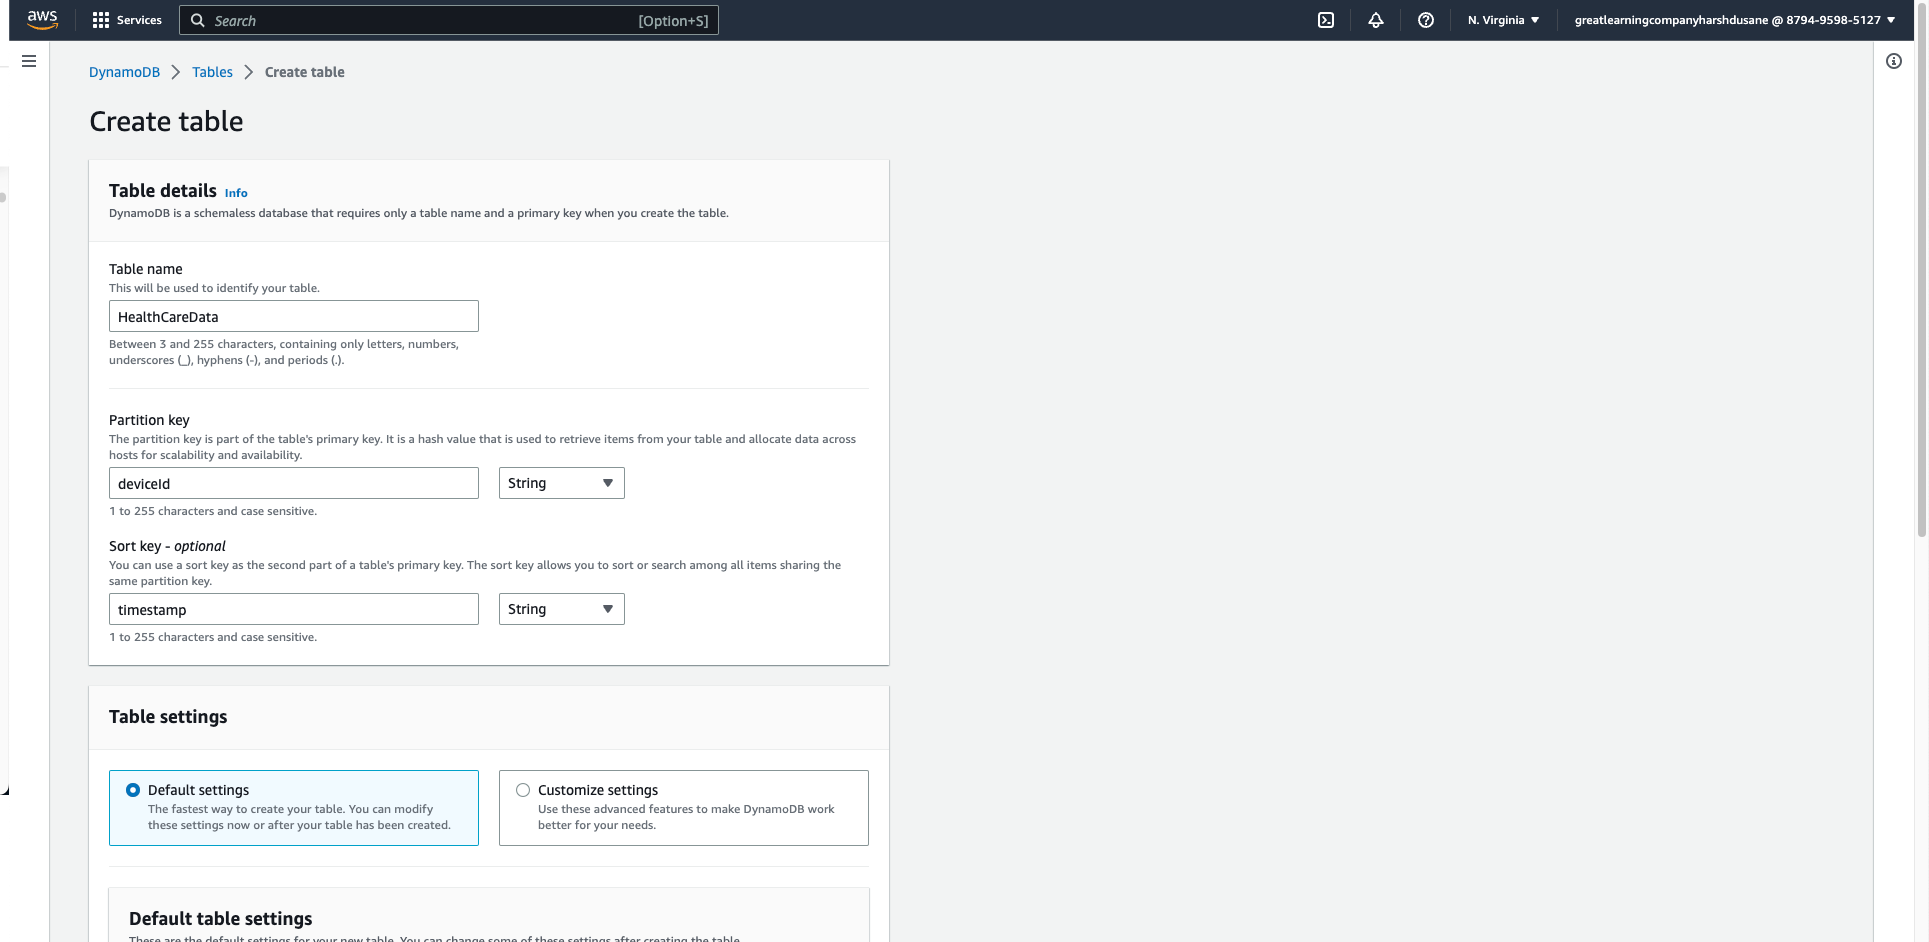

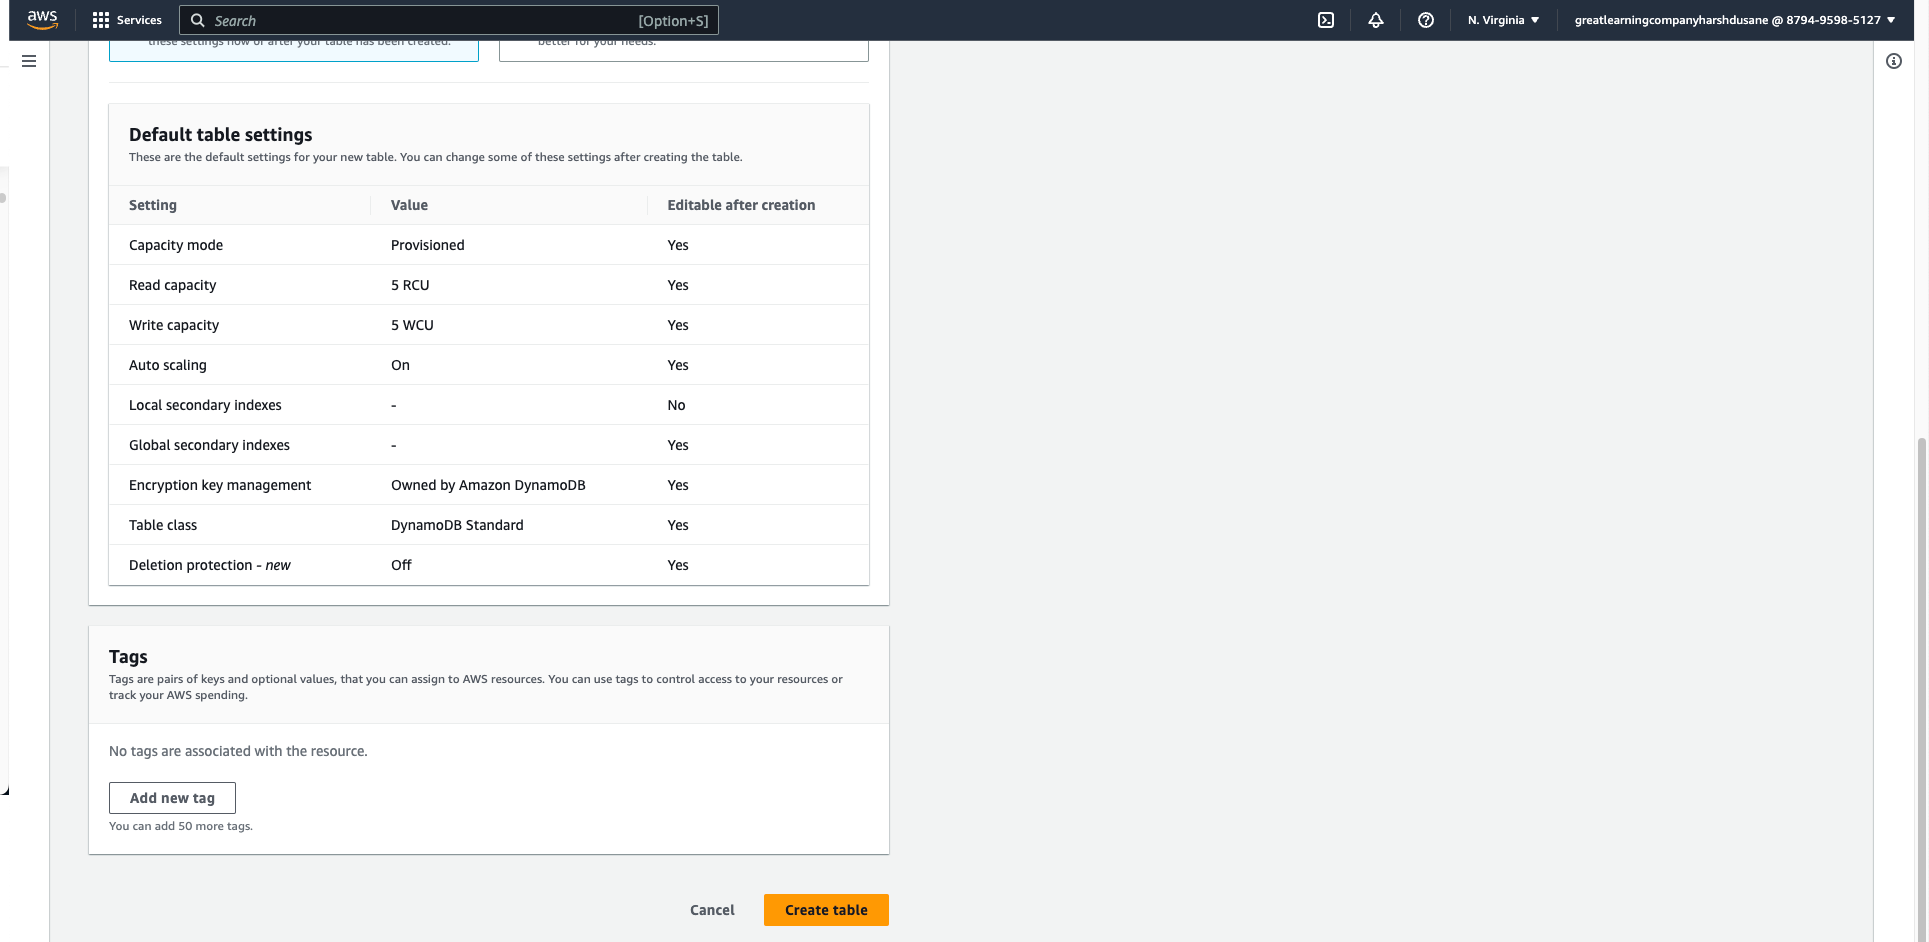

# <font color='blue'> Creating an IoT Thing </font>

We start with creating an **IoT Thing** - our listener - with an appropriate name. Then we setup an **IoT Core Rule** to direct all device data entering the IoT end Point, to populate the **DynamoDB** table we just created.

# <font color='blue'> Populating The DynamoDB Database </font>

We are all now familiar with the ```BedsideMonitor.py``` script we had created to generate device sensor data. we execute that same script to populate the **DynamoDB** table above:

```python BedSideMonitor.py -e <<endpoint>> -r <<root_certificate>> -c <<thing_certificate>> -k <<thing_private_key>> -id <<client-id>> -t <iot_topic>```

# <font color='blue'> Creating an IAM Role For EC2 </font>

Let us continue with a step that is largely independent of all other stages involved in setting up an **AWS CodePipeline**.

Ideally, AWS requires that we provision a specific **IAM User**, specify a **Role** for that user, and **attach** that role to the **EC2 instance** for the **CodePipeline** setup.

However, with the **AWS Educate Account** we use for these walkthroughs, provisioning additonal **IAM Users** is not possible. **AWS Educate** makes it easier for us, by allowing us to **directly create an IAM role for the logged in user credentials**, and attach that role to the **EC2 instance**.

We install a **CodeDeploy Agent** on the **EC2 instance** to deploy the application deployment, for which it needs several privileges.

* Ability to take the published artifact from the **S3 bucket** and install it on the **EC2 instance**
* Allow for **CodeDeploy** to make the deployment through the Agent
* When we ultimately setup the **AWS CodePipeline**, it needs to do the above two steps
* Since **CodeCommit** and **CodeBuild** are ultimately stages of our **CodePipeline**, we can add those privileges to the **EC2 instance** to be on the safe side

We have, in fact, reused an **IAM Role** we had used in earlier notebooks.

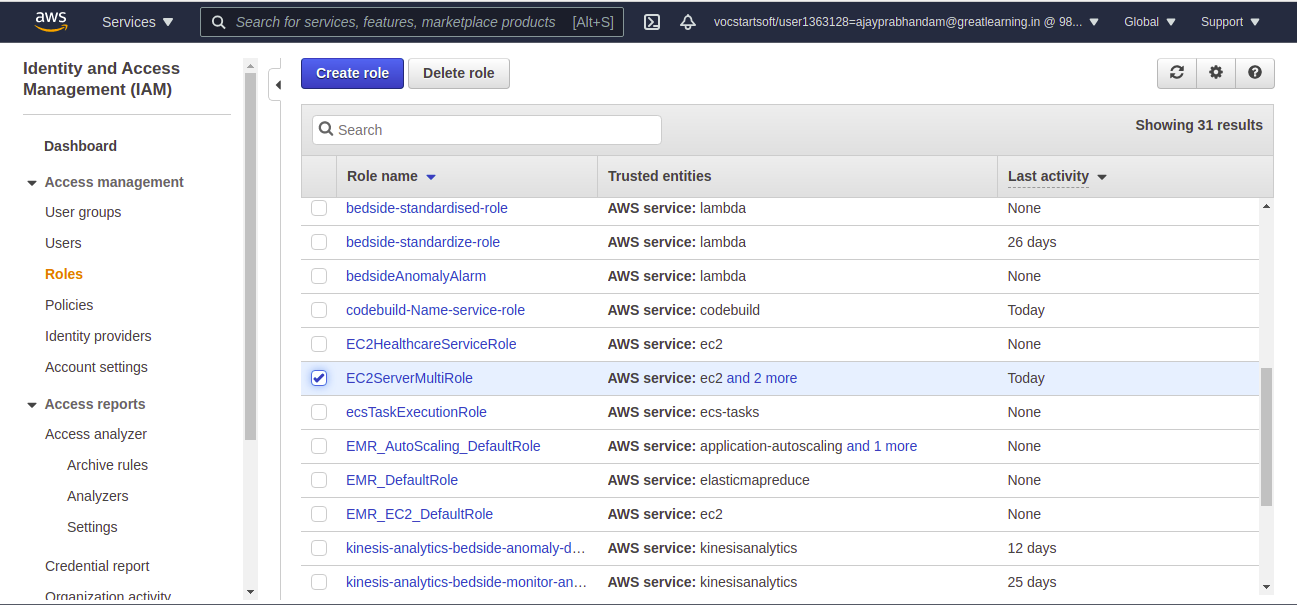

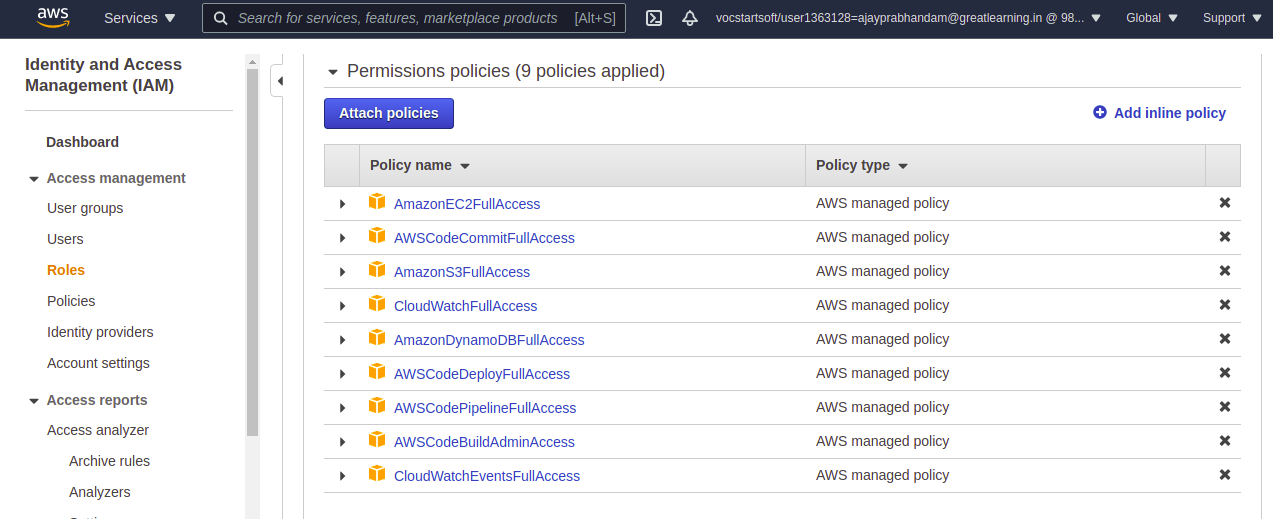

We hve already seem a summary of the various services accessed by the **EC2 instance**, and the **CodePipeline** we will be setting up. we will essentially be using the **same IAM Role** to provide them with those accesses. It would also help, in case of any errors, to also **Edit Trust Relationships** associated with this IAM role:

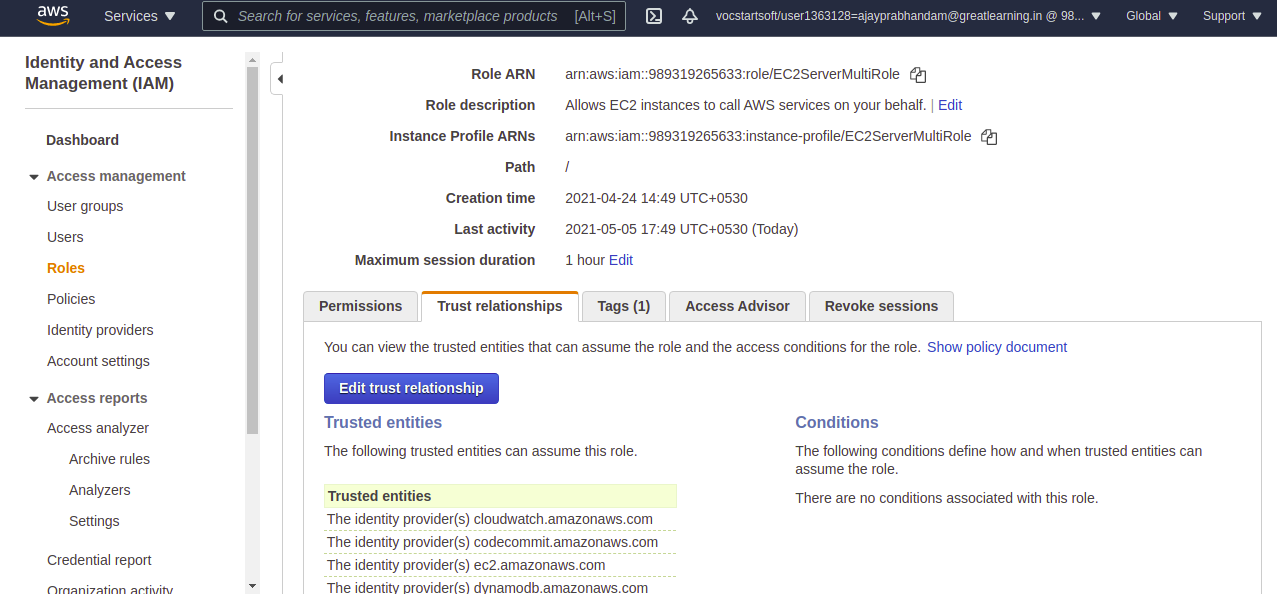

Here are the trust relationships we have enabled:

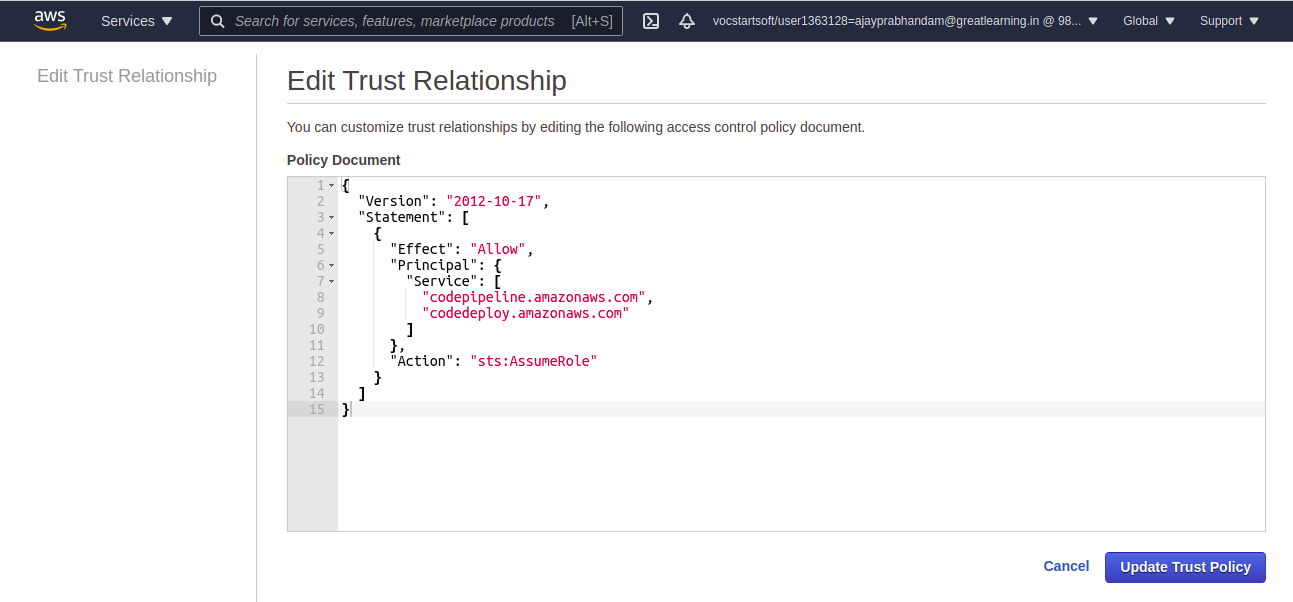

# <font color='blue'> Configuring EC2 Instances </font>

Let us now provision and launch an **EC2 instance**, which will be the target of our deployment:

* Here, we select the **AMI** to have **Ubuntu 18.04 LTS** packaged. We avoid the bleeding-edge Ubuntu 20.04 LTS, to be on the conservative side
* To this **EC2 instance**, we attach the **IAM role** we created a few steps earlier

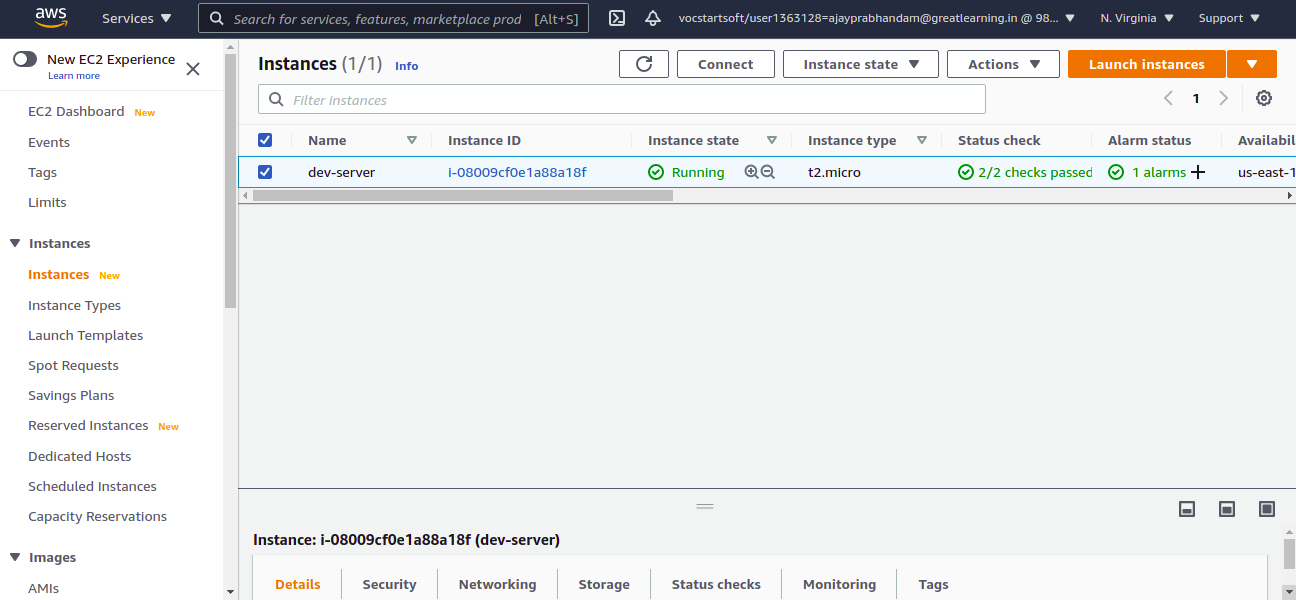

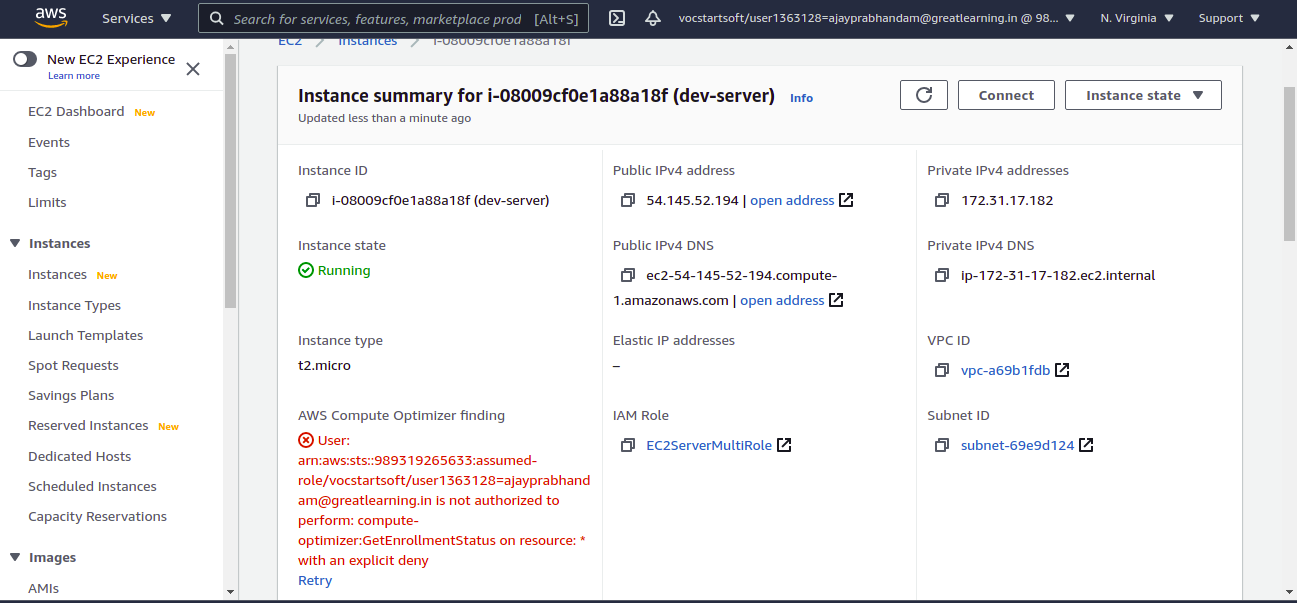

# <font color='blue'> Setting Up A CodeCommit Repository </font>

In our endeavour to setup a complete **AWS CodePipeline** for automated check-in and deploymnt of our application, the first step is to setup a **CodeCommit** repository.

**CodeCommit** is a **Git-based internal AWS code repository**, which we need to create and clone into our local development setup:

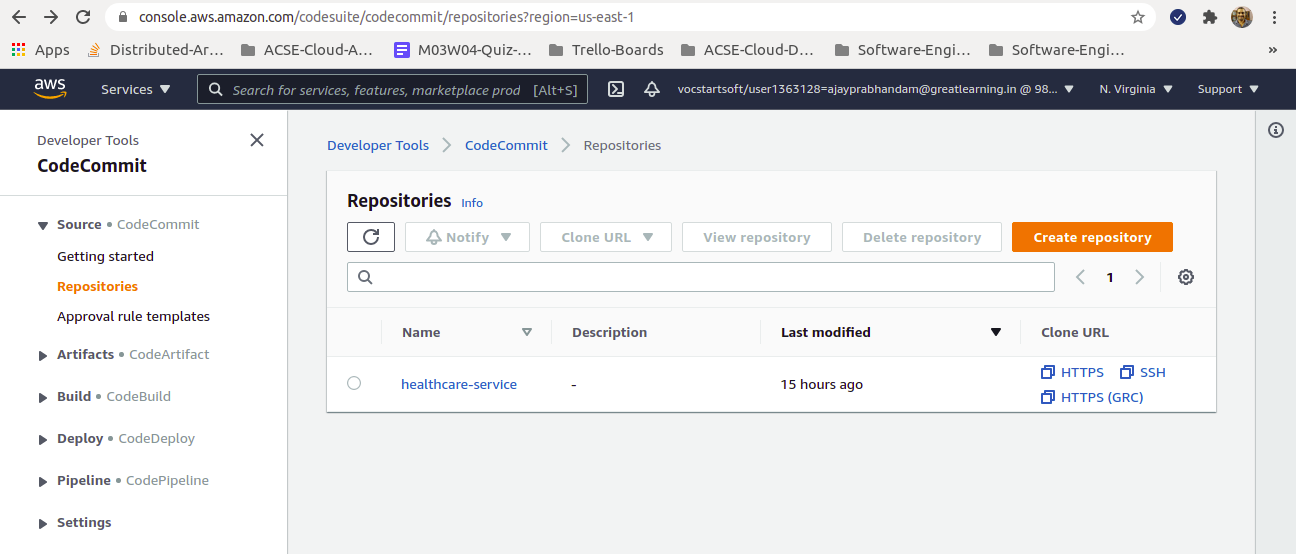

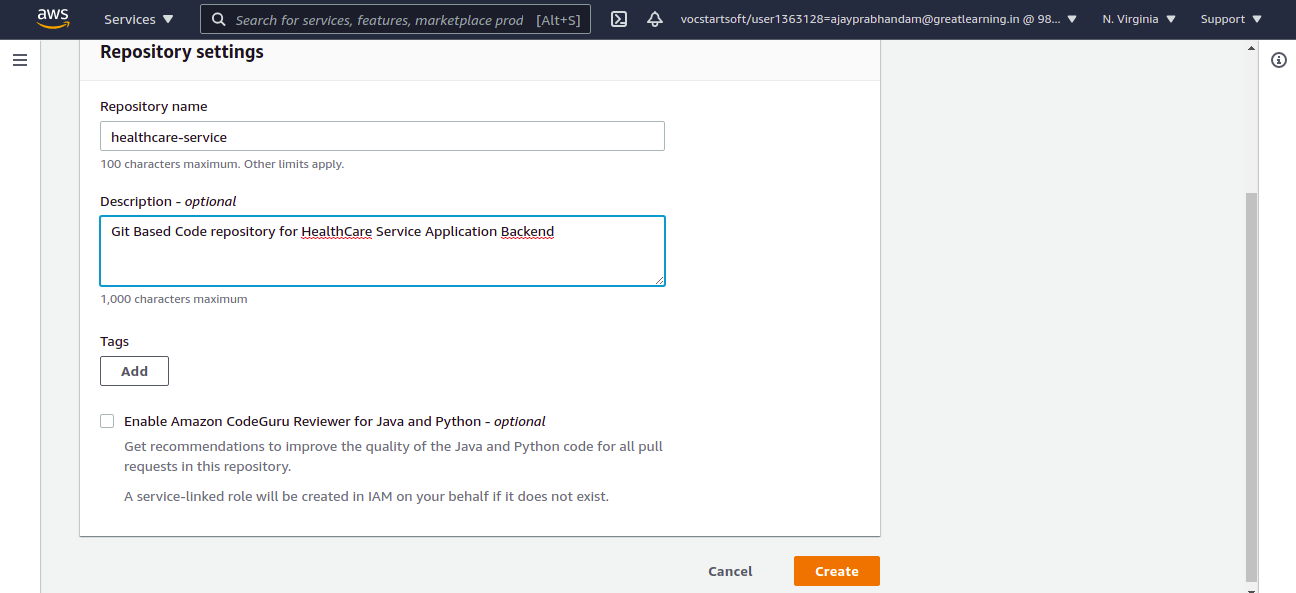

## <font color='blue'> Opting For HTTPS Over SSH </font>

Once the repository is created, the **CodeCommit** dashboard displays some additonal information and instructions.

**CodeCommit** clearly mentions that for **SSH** access from a remote terminal, the current setup ins insufficient. We need to provision an additional **IAM User**, create a **Role for it**, and use those credential for remote access.

However, we just saw that the **AWS Educate** account we use does not allow that, and even does not provide any workaround for this.

Note that **HTTPS** access is not as particular as **SSH** - even with the current user credentials, **HTTPS** enables remote access - just that it is not recommended. Since we are only trying to deploy a sample application with no commercial ambitions, we can proceed.

We copy the **HTTPS URI** exposed by this **CodeCommit** repository, and use that to clone that Git repository into our local development machine.

We choose a suitable folder in our local machine, and clone the Git **CodeCommit** repository with the following command:

```git clone <CodeCommit-HTTPS-URI>```

While creating this walkthrough, it turned out to be:

```git clone https://git-codecommit.us-east-1.amazonaws.com/v1/repos/healthcare-service```

This created a folder named ```healthcare-service``` in the curent folder (where the command as executed), which is a local clone of the **CodeCommit** repository.

# <font color='blue'> Committing The Codebase To CodeCommit </font>

## <font color='blue'> Setting Up appspec.yml And Related Scripts </font>

We now have the **CodeCommit** repository cloned. It is currently empty, so we now get a chance to add our codebase there.

This is the intended folder structure of our **Healthcare Service Backend**:

-- backend

  |
  
   -- appspec.yml 
     
  |
  
   -- scripts
  
  |
  
   --
     
     |
    
      -- pre-install.sh
      
     |
  
      -- post-install.sh
      
     |
     
      -- healthcare-start.sh
      
     |
     
      -- heathcare-stop.sh
   
  |
  
   -- service
   
     |
     
      -- backend
   
        |
     
         -- healthcareService.py
      
        |
     
         -- requirements.txt

      
      
The ```service``` folder containes the source code and configuration.

The ```appspec.yml``` file (A **YAML** file) is what the CodeDeploy Agent executes on the **EC2 instance** when the deployment needs to be made.

The ```scripts``` folder contains **bash shell scripts** (specific to Linux - here, our **Ubuntu AMI**) that run various stages of the deployment process.

We archive the ```backend``` codebase folder into a **zip archive** - ```backend.zip``` - before we store it in the **CodeCommit** repository that we cloned earlier.

## <font color='blue'> HTTPS Session Expiry: Options </font>

First, we save the ```backend.zip``` archive into the ```healthcare-service``` folder, which is where the CodeCommit repository is locally cloned.

We now run the following git commands to push it into the remote repository:

* ```git add *```
* ```git commit -m '<Commit Message>'```
* ```git push origin```

Often, we may encounter a very **irksome error** while trying to push the codebase to the CodeCommit repository. This is because the **AWS Login Credentials** time out preiodically, and need to be refreshed.

To succesfully push the codebase to the remote repository using a HTTPS connection, we need to refresh those credentials locally. 

First, copy the **AWS Connection Details** from the **AWS Educate Vocareum Landing Page**:

<img src="http://drive.google.com/uc?export=view&id=19NQzT1hWooQk5f_-qd8RrCyiL_LuOGBc" width=1200px>

<img src="http://drive.google.com/uc?export=view&id=1xiz_Rajrhvu0H1Nfys2aivsr7HUVBG3o" width=1200px>

Now, open the local file ```~/.aws/credentials``` and paste thee connectin details over the previous ones. In addition to these, we need to add a credential detail as follows:

* ```region=<AWS-Region>```
    
In our case, ```<AWS-Region>``` resolves to ```us-east-1```. If we re-run the ```git push origin``` command, it will succeed this time. Be prepared to repeat thsi everytime you face such an error.

# <font color='blue'> Creating An S3 Bucket - Artifact Repository </font>

There are only two kinds of locations from where an **AWS CodeDeploy** stage can pick up built artifacts:

* An S3 bucket
* A Git repository

In this walkthrough, we will aim to keep things simple. Let us create an **S3 bucket** to store the built artifact. We will use this bucket name as part of our **CodeBuild Build Project** configuration, later.

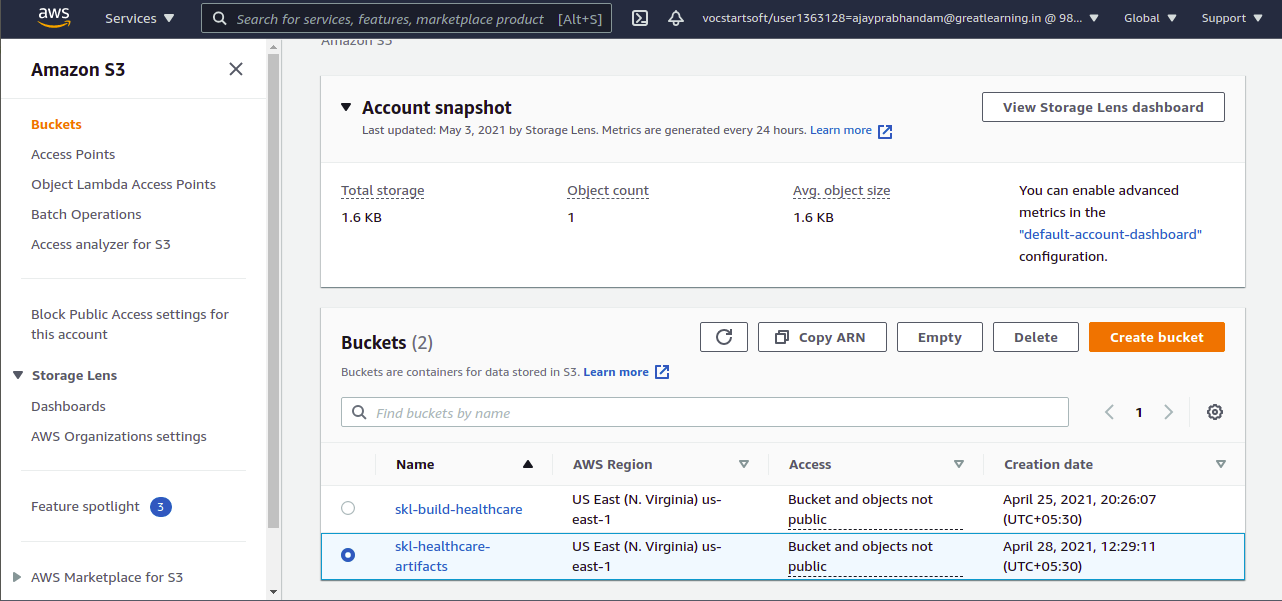

We then create the desired folder structure, within this bucket:

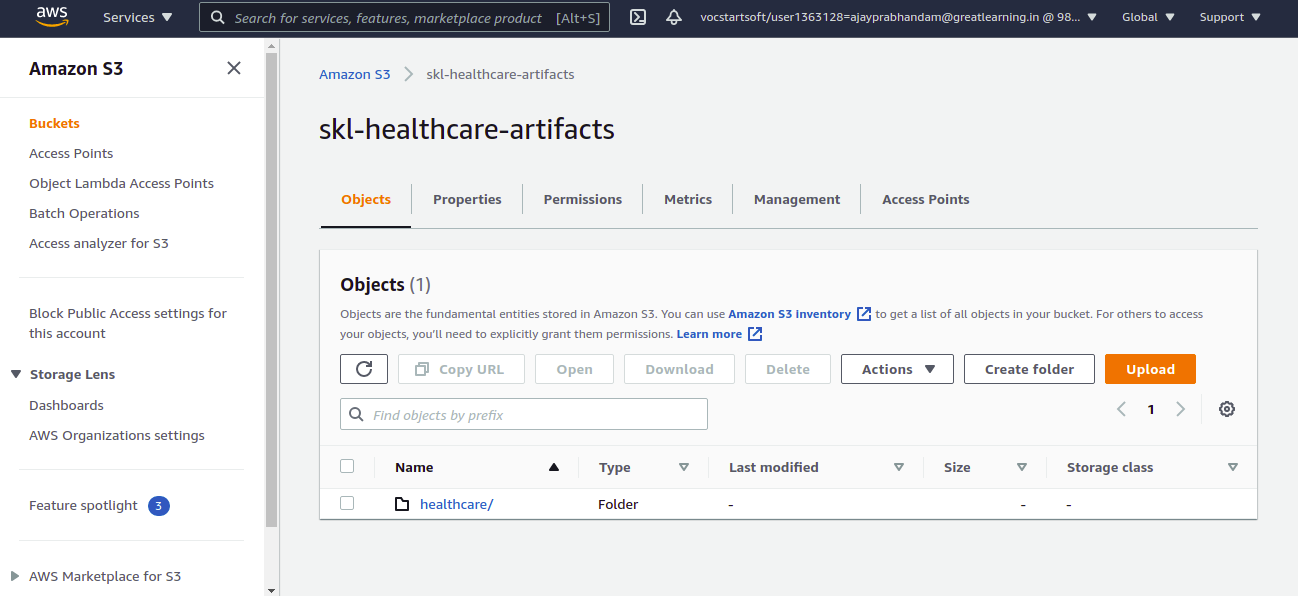

# <font color='blue'> Creating A CodeBuild Project </font>

We have now successfully committed our codebase archive into the **CodeCommit** repository. The next step is to configure a **CodeBuild** stage to take this codebase, run a build on it, and save the generated artifacts in an artifact repository.

We start with creating a **Build Project**. As part of this configuration, we also mention the **S3 bucket** where we intend to store the generated build artifact. We start with the project name:

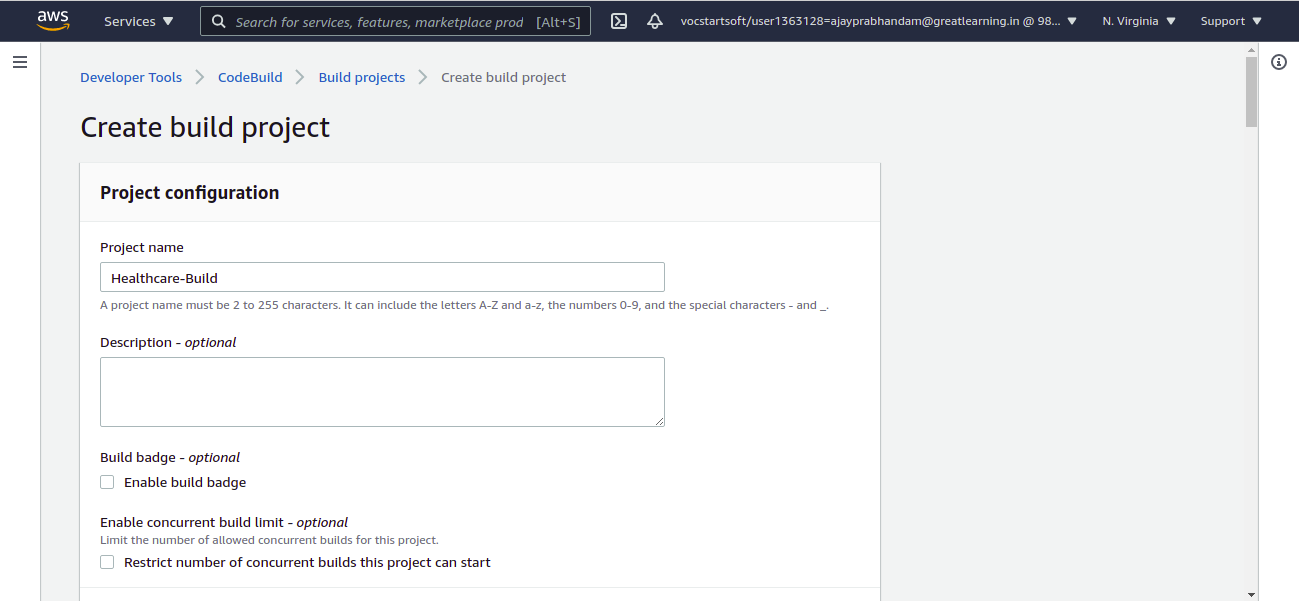

Specify the **Source Provider**, which is the **CodeCommit repository** from where the project picks up the codebase to build.

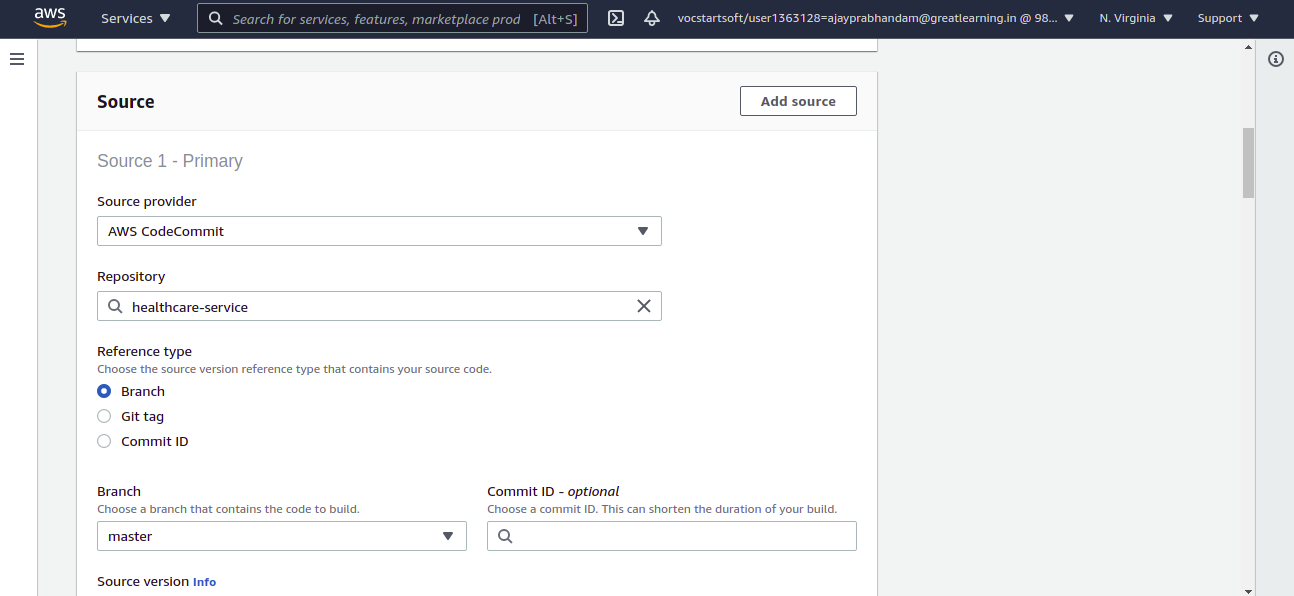

We specify the **git branch** as well - ```master```. Next, we configure the enviroment, specifying a managed AWS CodeBuild image running Amazon Linux 2, from the choices available:

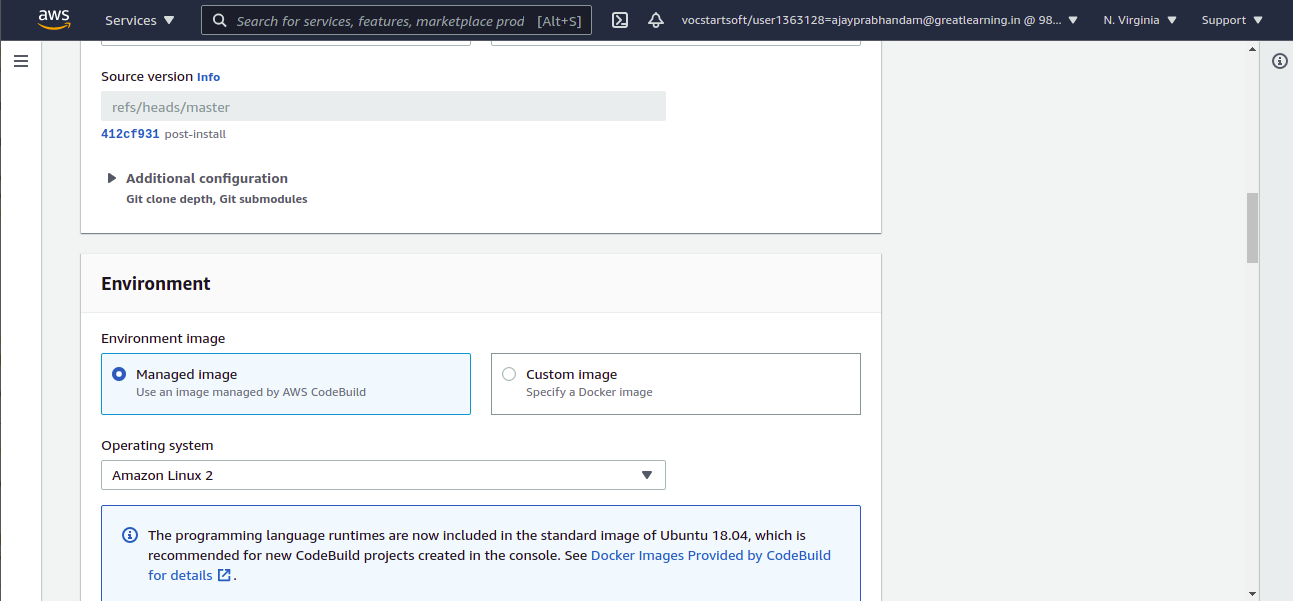

After selecting the image, w erealize we intend to build a Python 3.7+ codebase. Note that CodeBuild runs the build inside a custom docker container that it launches based on our environment configuration. For that purpose, we select a suitable Standard Docker image version from the list available at the following location:

**Docker Images Provided By CodeBuild**: [https://docs.aws.amazon.com/codebuild/latest/userguide/build-env-ref-available.html](https://docs.aws.amazon.com/codebuild/latest/userguide/build-env-ref-available.html)

We select the suitable options. We also decide to create a fresh Service Role for use by this CodeBuild project. We will need to edit this role soon, to make sure CodePipeline is compatibel with our CodeBuild stage.

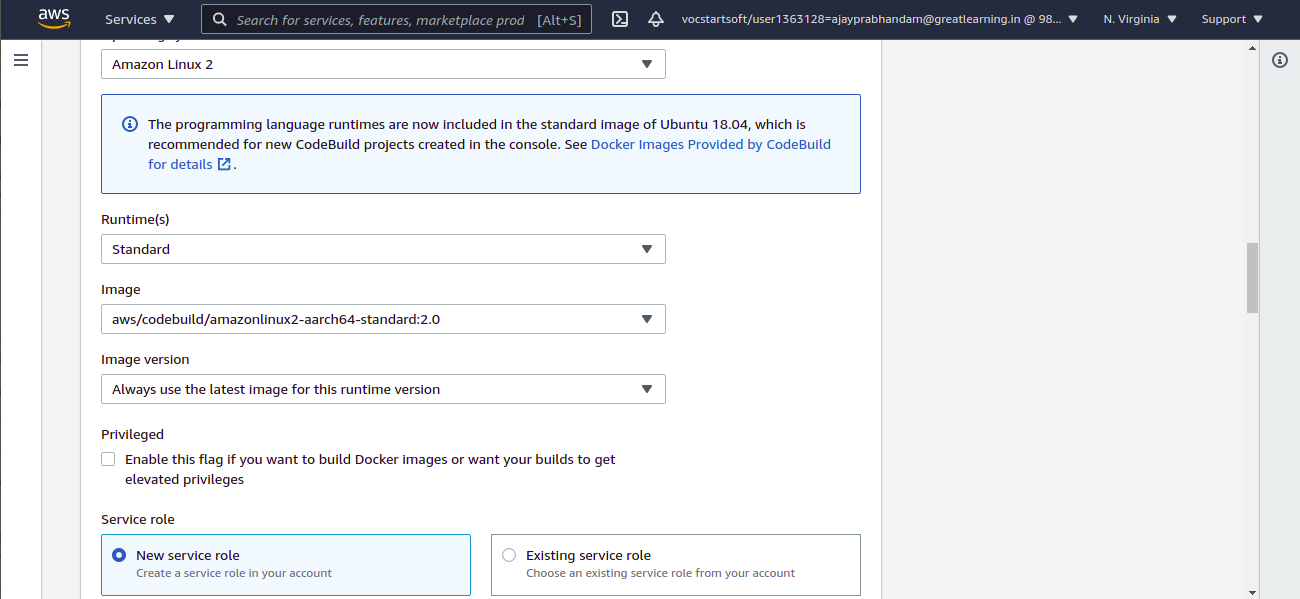

We give the Service Role a suitable name. we also choose to use a BuildSpec file, which we will edit in a short while.

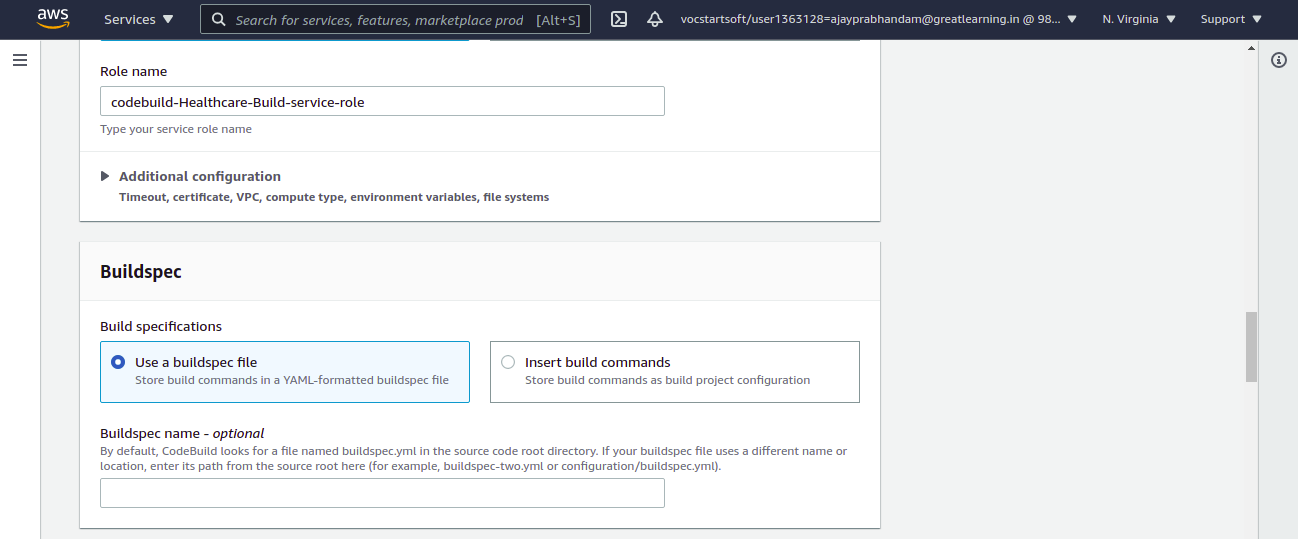

Next, we configure the Artifact Repository. Thsi is where the project will push artifact revisions after the buils, and we created an S3 bucket a short while ago. we enter the bucket details:

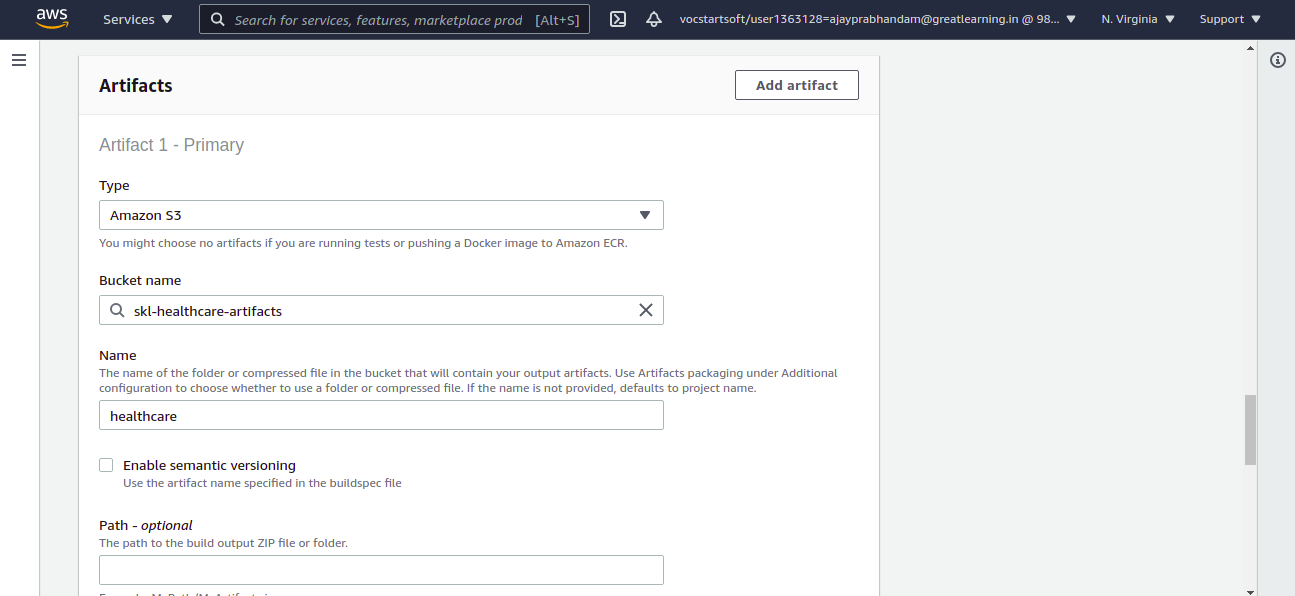

As part of the artifact packaging, we select ```None```, since the said artifact is already a ```zip``` archive:

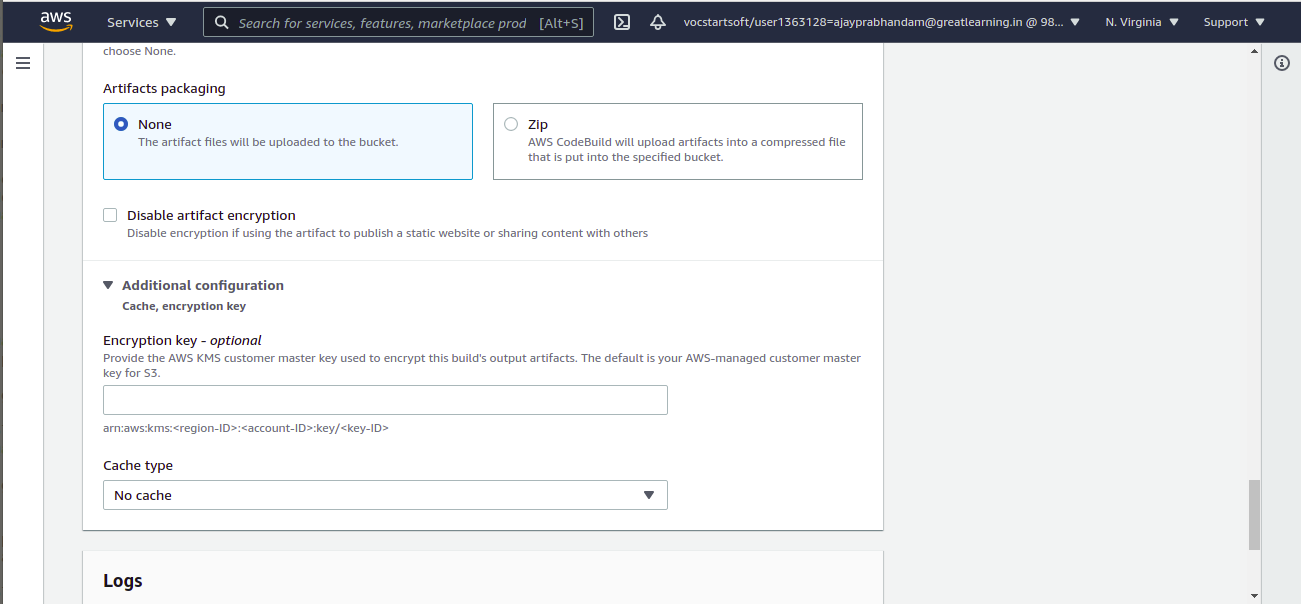

Wre leave the rest of the settings with their default values, and disable any CloudWatch Log settings, to keep things simple. Then, we click on ```Create Project```:

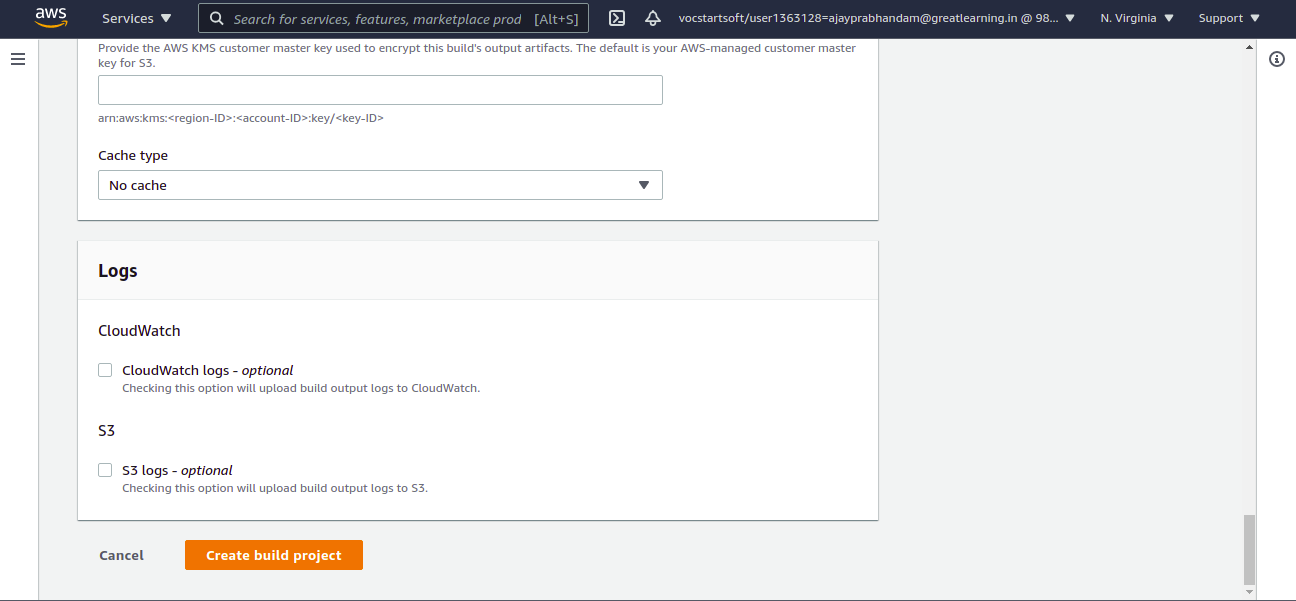

As mentioned, we will now edit the CodeBuild Project Service Role we just created:

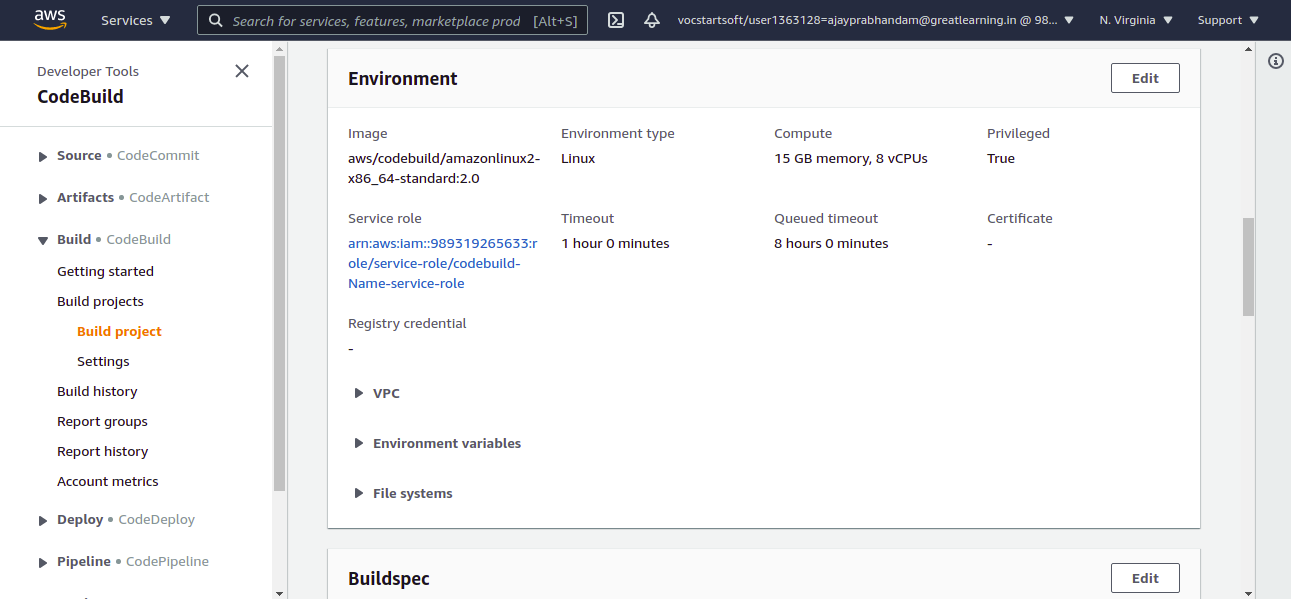

We attach the following policies to this Service Role:

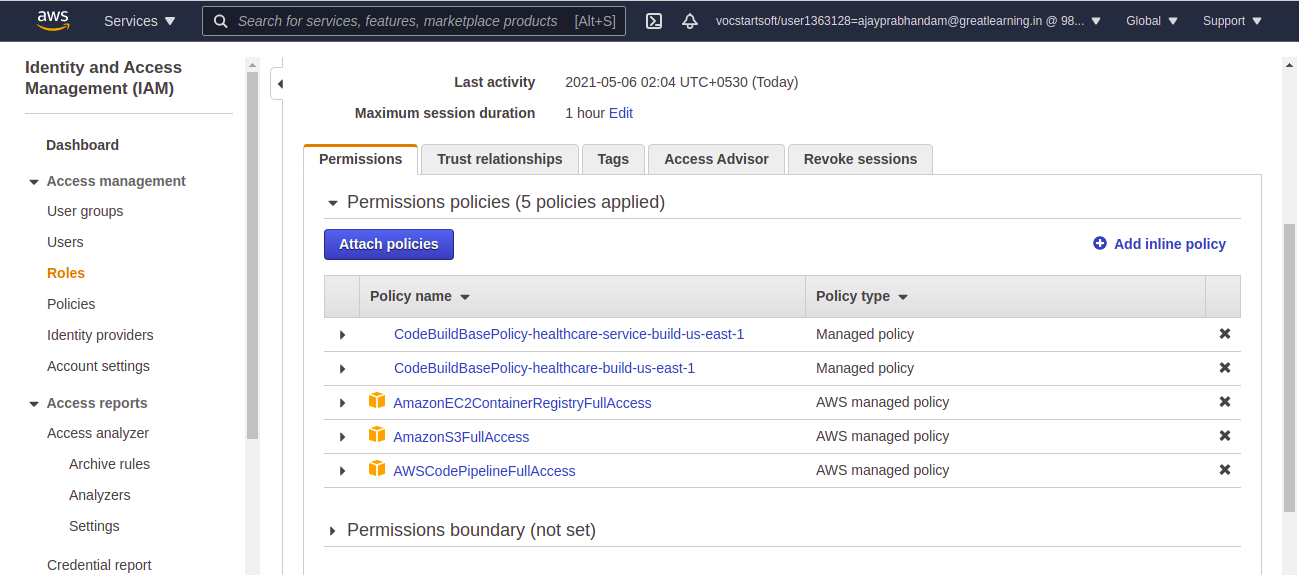

The current setting will work fine for a standalone CodeBuild phase. However, when we need to add this phase as a stage of a CodePipeline pipeline, we will need to ensure the CodeBuild project trusts the CodePipeline service. For this, we click on ```Edit Trust Relationships```, and add a trust setting as follows:

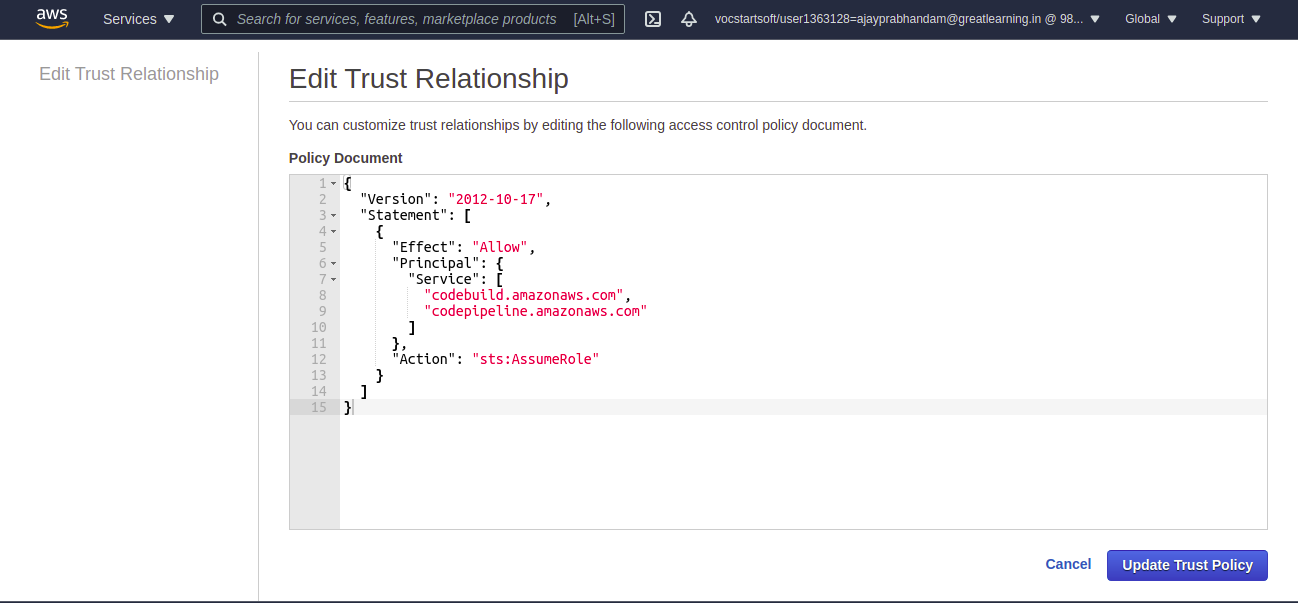

The Service Role is now set to be used by CodePipeline.

# <font color='blue'> Setting Up buildspec.yml </font>

Now that we have created a basic **Build Project**, it is time to specify a few build instructions. The instructions sit in a **YAML** file named ```buildspec.yml```, which contains specific commands for various build stages.

Actually, all we intend to do as part of this stage is: 

* Take the code base archive from the **CodeCommit** repository,
* Label it as an **artifact file**, and
* Store this artifact in an S3 bucket, for later access by the CodeDeploy stage

Below is the ```buildspec.yml``` that we use for our purposes. The artifacts files specified are:

* ```appspec.yml```
* The ```scripts``` folder containing hook shell scripts (We will describe these at the deploy stage)
* The codebase: ```backend.zip```

In [ ]:
# WILL NOT EXECUTE!

version: 0.2

#env:
  #variables:
     # key: "value"
     # key: "value"
  #parameter-store:
     # key: "value"
     # key: "value"
  #secrets-manager:
     # key: secret-id:json-key:version-stage:version-id
     # key: secret-id:json-key:version-stage:version-id
  #exported-variables:
     # - variable
     # - variable
  #git-credential-helper: yes
#batch:
  #fast-fail: true
  #build-list:
  #build-matrix:
  #build-graph:
phases:
  install:
    commands:
      # - command
      # - command
  pre_build:
    commands:
      # - command
      # - command
  build:
    commands:
      # - command
      # - command
  post_build:
    commands:
      # - command
      # - command
artifacts:
  files:
    - appspec.yml
    - backend.zip
    - scripts/*
  #name: $(date +%Y-%m-%d)
  #discard-paths: yes
  #base-directory: location
#cache:
  #paths:
    # - paths

We make the above edits to the available ```buildspec.yml``` template, and save it:

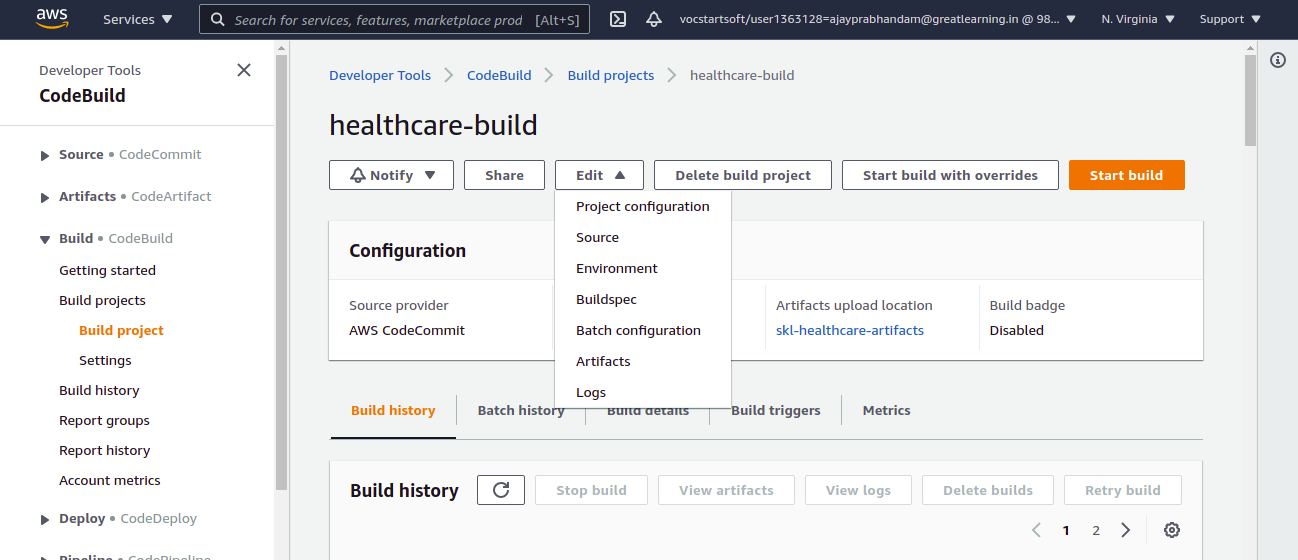

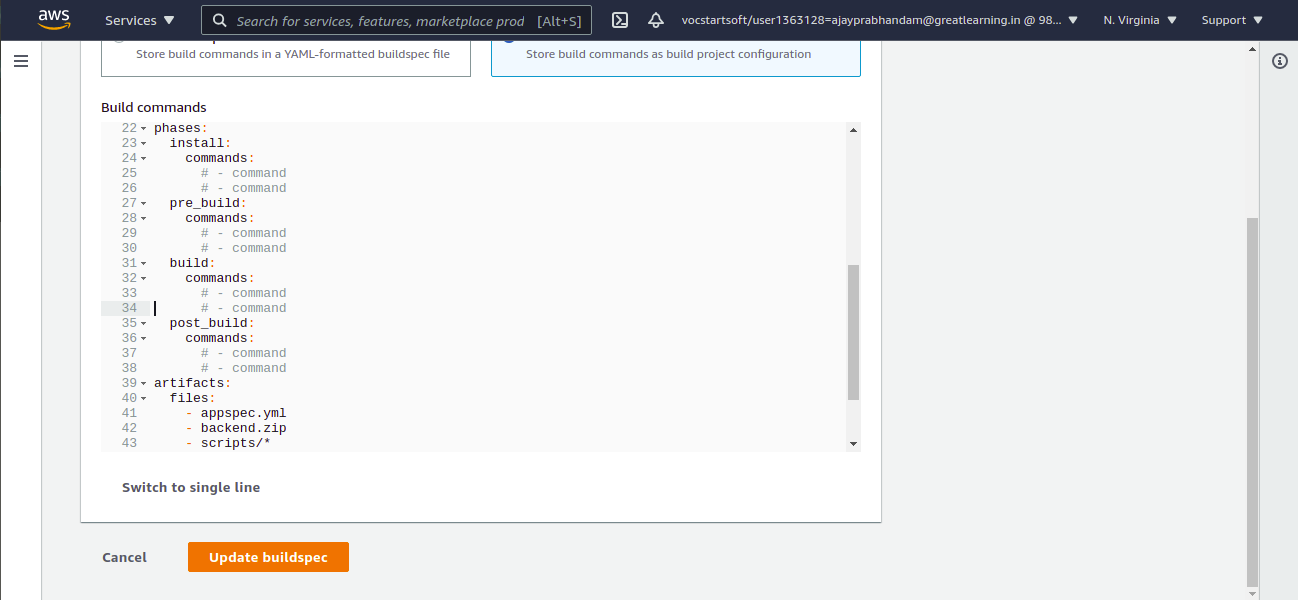

# <font color='blue'> Running A Build With CodeBuild </font>

With the build instructions out of the way, it is time to run a build, by clicking on the ```Start Build``` button:

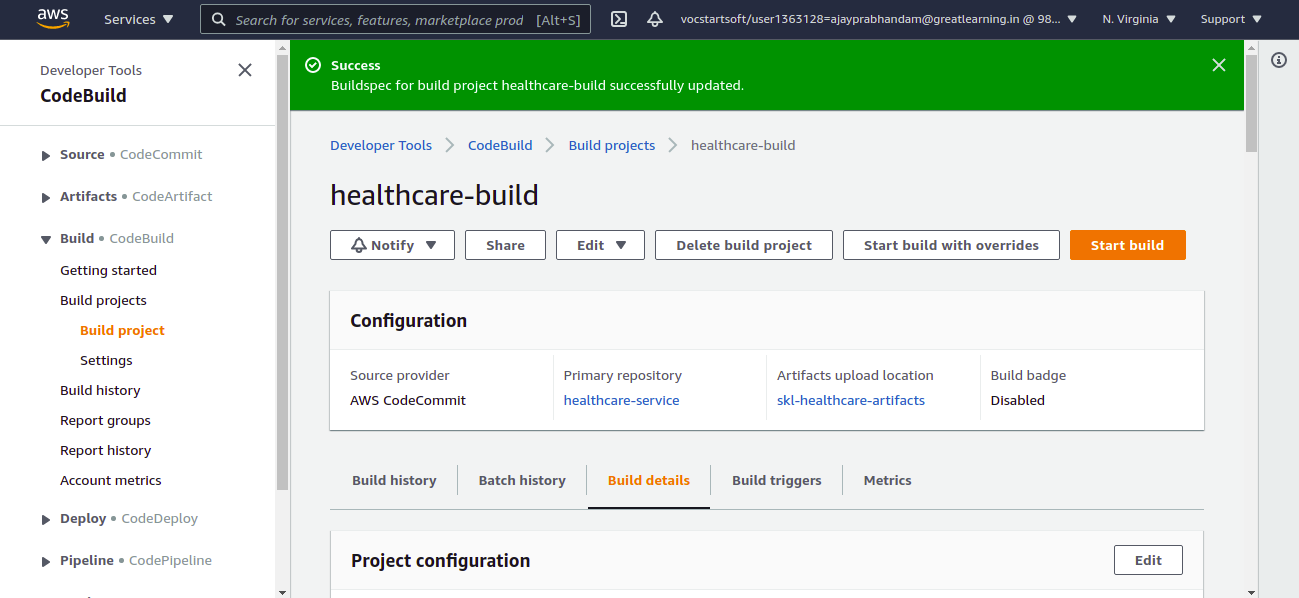

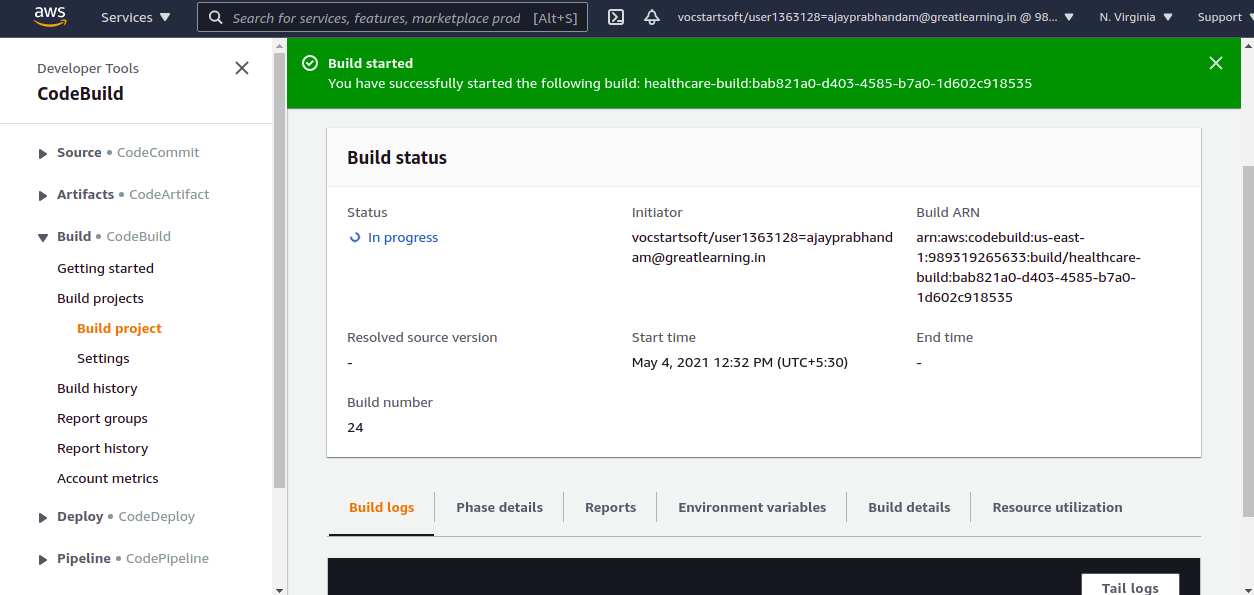

We can see that the build is in progress. We can scroll down and click on the ```Tail Logs``` button to view the logs at run-time:

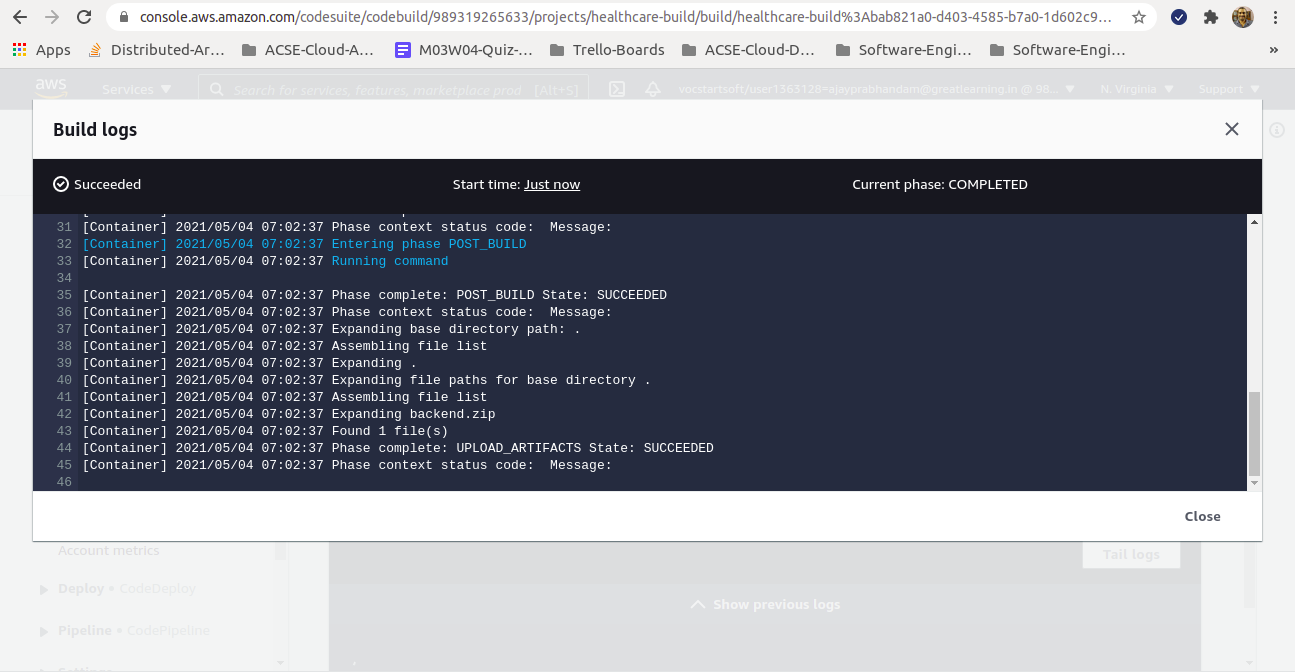

At last, the build has succeeded. This process would store the artifact into the S3 bucket we had created for this purpose, earlier.

# <font color='blue'> Verifying The Artifact Repository </font>

If we visit the **S3 bucket** we had created earlier, we find the artifact created in the folder that we had specified:

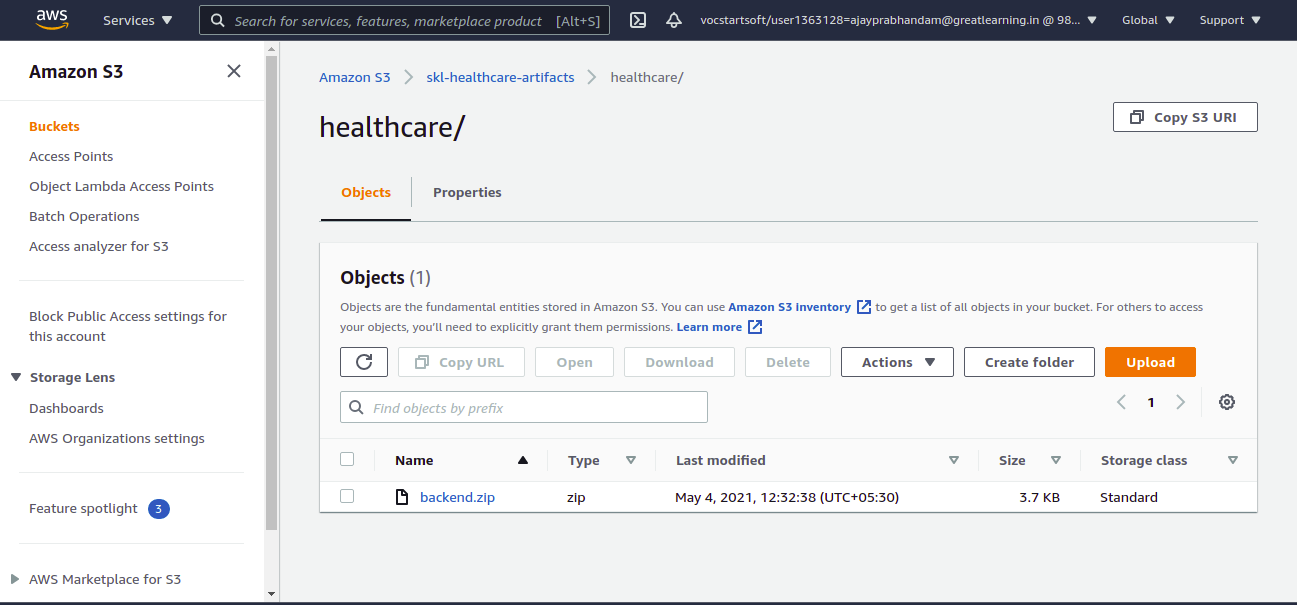

# <font color='blue'> Creating A CodeDeploy Application </font>

We have now crossed the **CodeBuild** stage, and it is time to hit the **CodeDeploy** stage. For that, we start by creating a **CodeDeploy Application**:

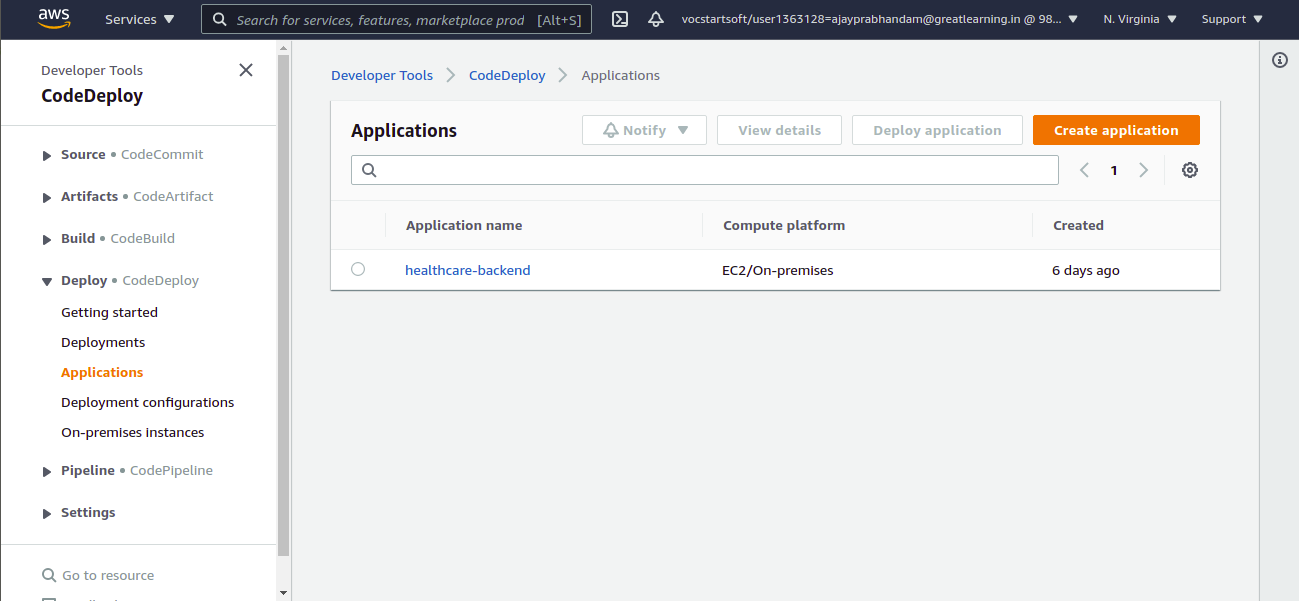

We choose the target where we deploy the artifact as ```EC2/On-premises```, since we intend to deploy it directly to an **EC2 instance**:

<img src="http://drive.google.com/uc?export=view&id=1IHDPe9OPKBlJKRgoe8eD3dv_DdxBF53w" width=1200px>

# <font color='blue'> Creating A Deployment Group </font>

We now create a **CodeDeploy Deployment Group**, which houses the entire history of **Deployments** configured in this manner.

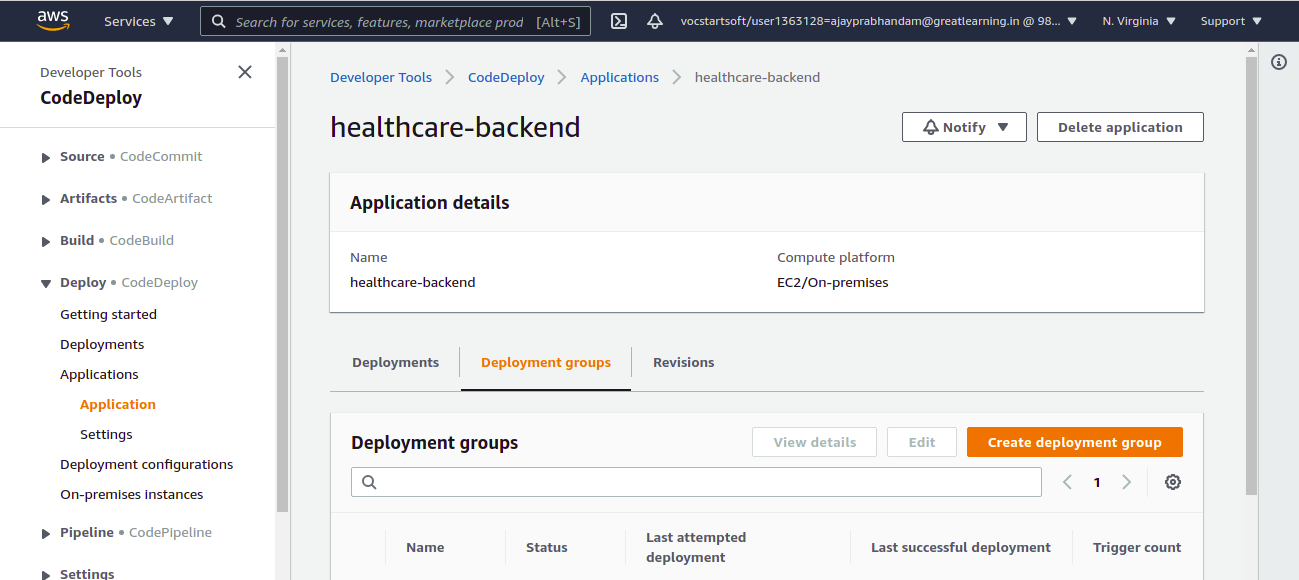

We need to provide the **IAM Role** we had created for use by CodeDeploy, on the **EC2 instances**:

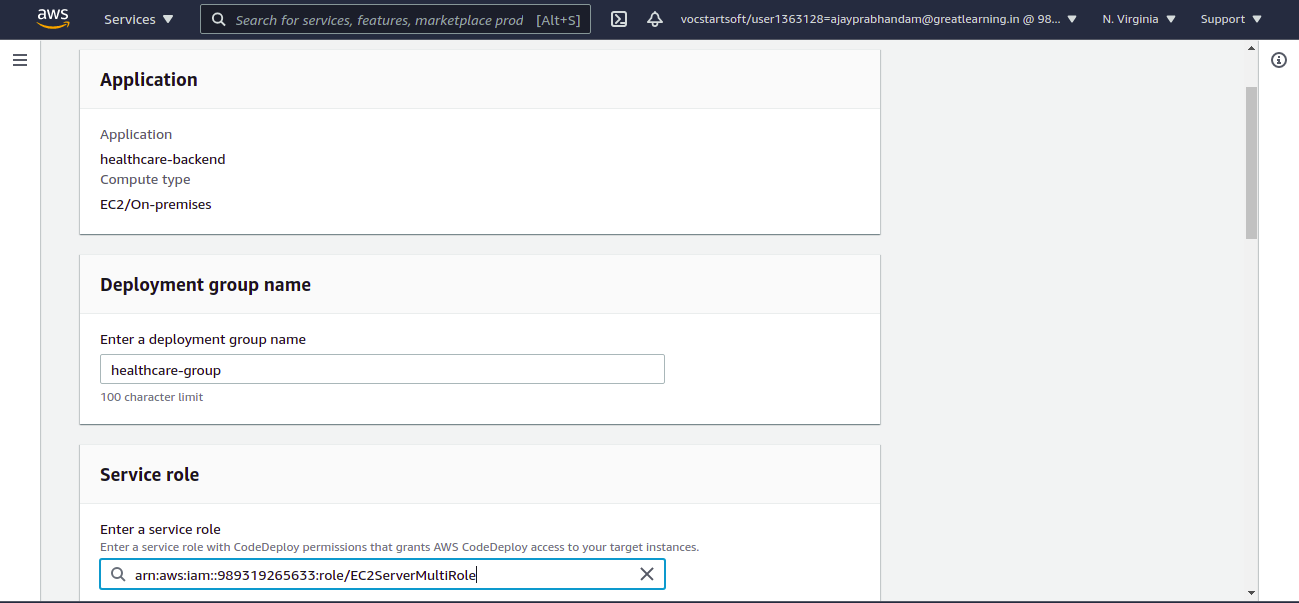

For deployment type, we can either choose ```In-Place Deployment``` or ```Blue-Green Deployment```, both of which have been introduced in the learner videos. here, we select the former.

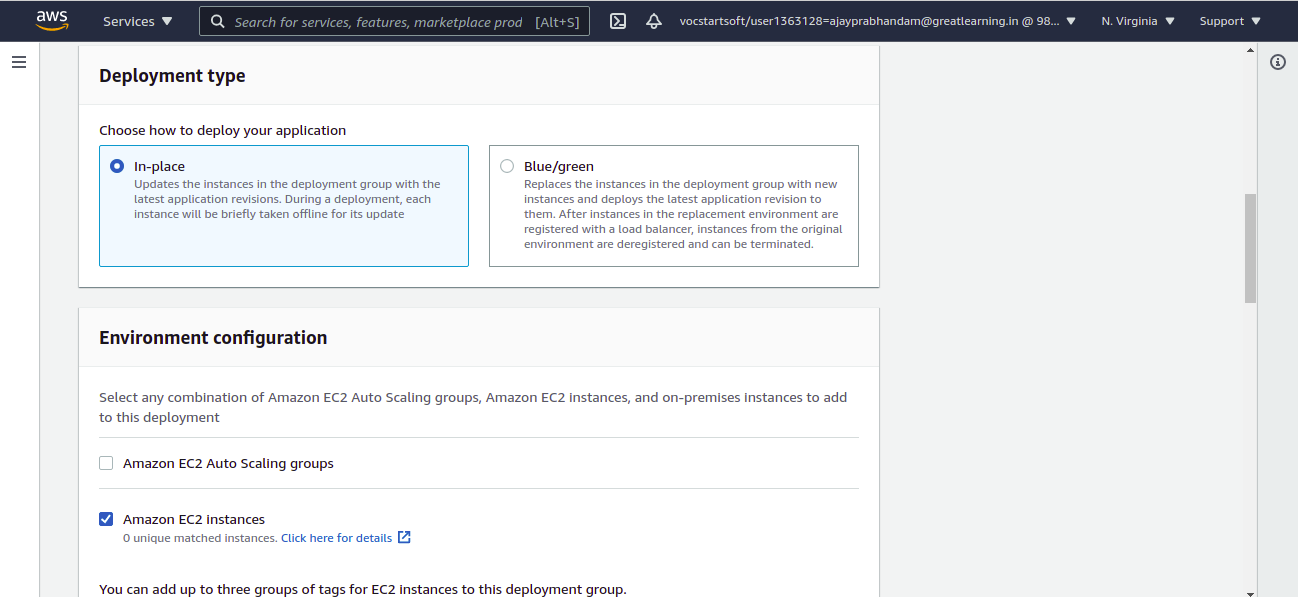

When we select the targets as ```EC2 instances```, we are allowed to select specific instances using tags. If you recall, we had assigned a **Tag** with **name** ```Type``` and **value** ```backend-server``` for the **EC2 instance** we created earlier. if we use the same tags here, **AWS internally identifies** that **EC2 instance**.

The advantage of using tags is that we could create **multiple EC2 instances with the same tag name and value**, and **CodeDepoy** would **select all those instances** to deploy the application revision to.

So far, we have created just a single **EC2 instance** with this tag, so AWS identifies that.

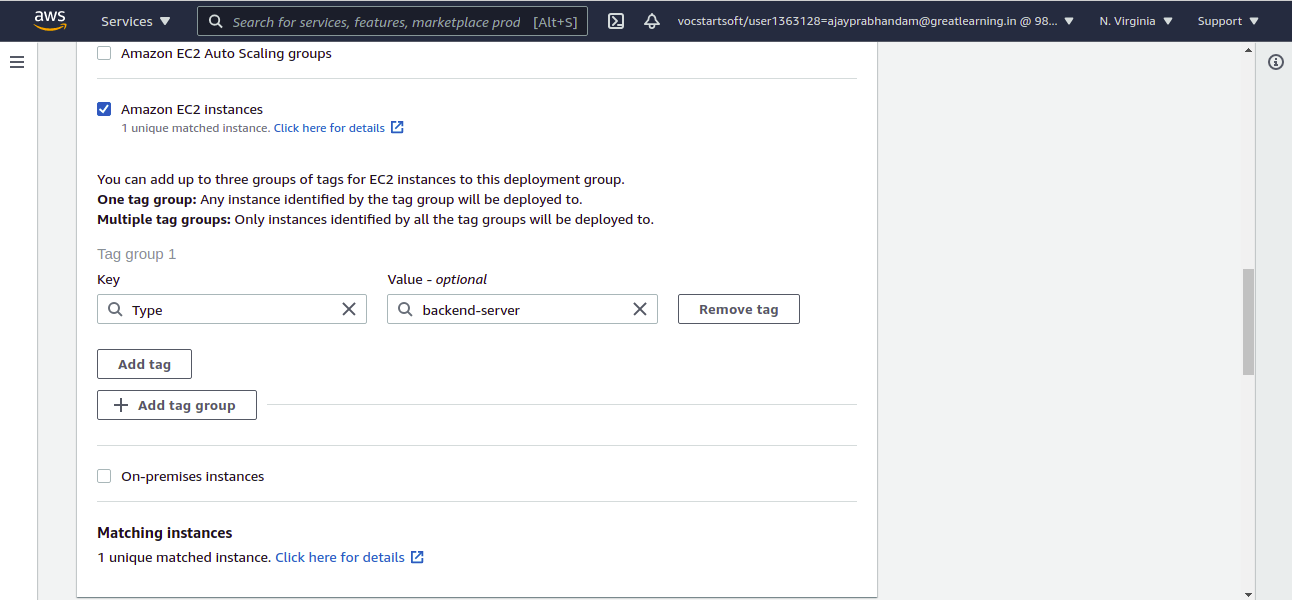

Note that **AWS** alerts us with a message, urging us to fulfil certain **prerequisites** before we install a **CodeDeploy Agent** into those **EC2 instances**. These prerequisites also involves the creation of a specific **IAM User**, and creating a **Role** that includes **CodeDeploy** access policies.

As stated earlier, we have used the **AWS Educate Account** workaround to directly create an **IAM Role** with the necessary policies. We just assigned that **IAM Role** to this **Deployment Group** a few screens earlier.

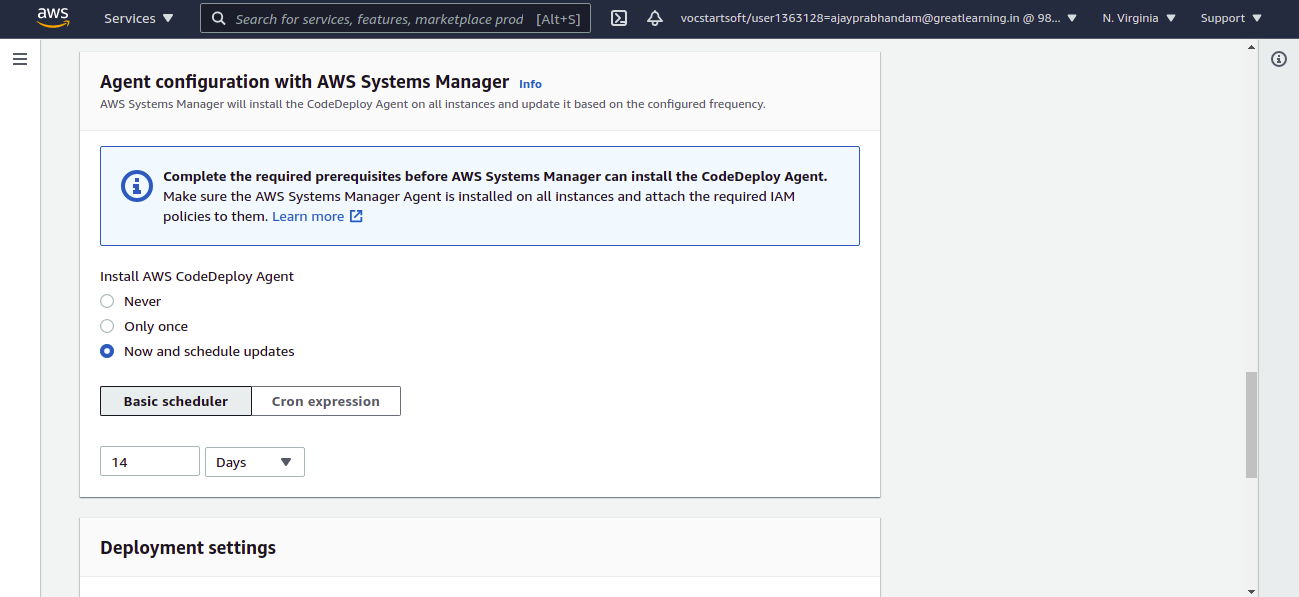

Under ```Deployment Configuration```, we choose a configuration that deploys **artifact revisions** to all the **EC2 instances** in the cluster, at once.

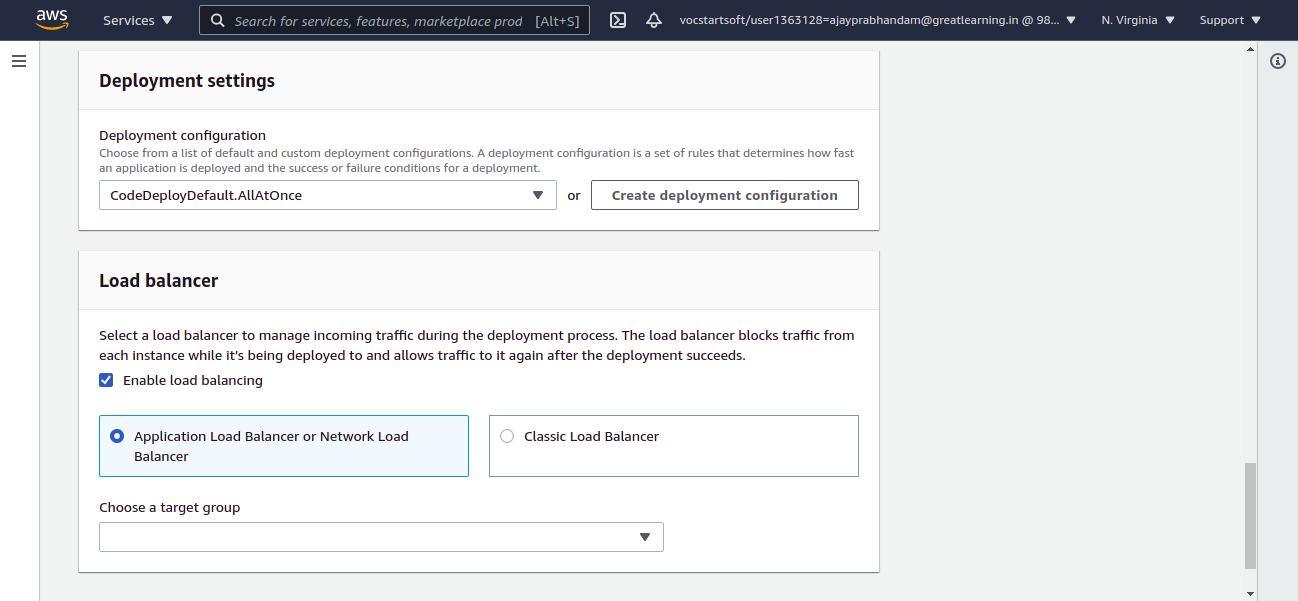

Finally, there is a configuration for including any load balancer our application infrastructure might use. The supported ones are the Application Load Balancer (ALB), and the Classic Load balancer.

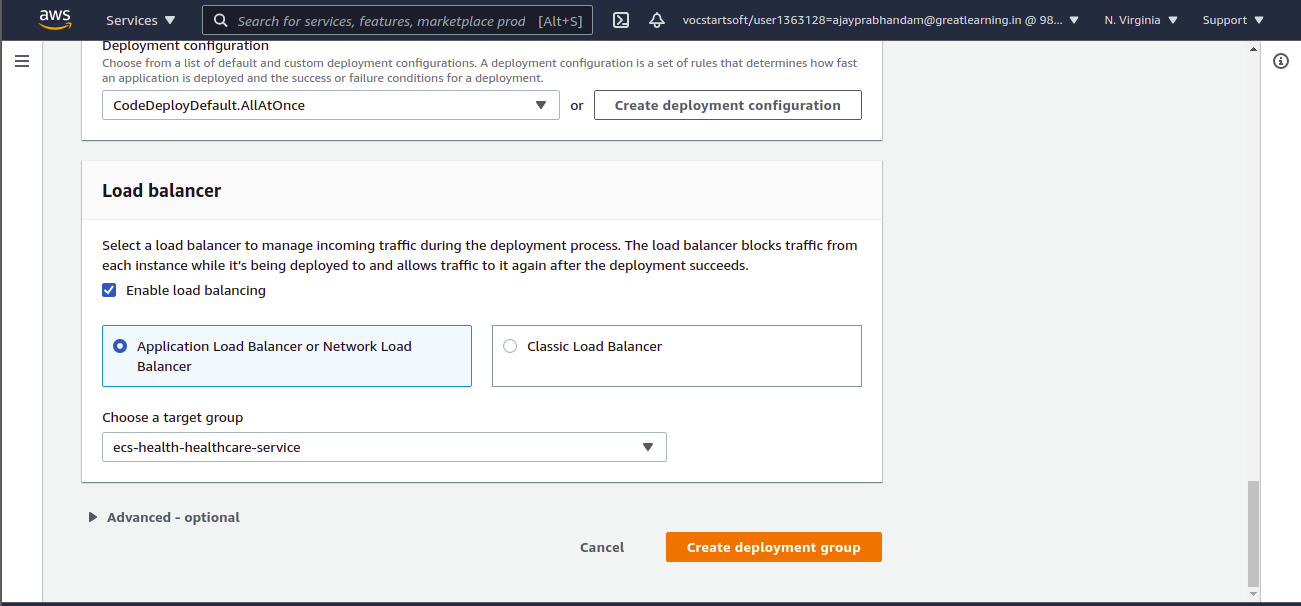

**We choose not to have any load balancer, since we have just a single EC2 instance to deploy to.**

# <font color='blue'> Installing The CodeDeploy Agent On The EC2 Instance </font>

Before we create and launch a deployment, we need to install the **CodeDeploy Agent** on the **EC2 instance** we launched earlier. 

Confirm that the instance is in a "**Running**" state before doing this. Confirm also, that we have followed the standard procedure of downloading the **PEM** file after instance creation, and that we have run the following command on it:

```chmod 400 <PEM-file>```

Now, click on the ```Connect``` button on the **EC2 Dashboard**, for the running **EC2 instance**. This will give us the **SSH URL** of this running instance, and we connect to it using **SSH**:

```ssh -i <PEM-file> <EC2-Instance-URL>```

Once inside, we need to run a few commands. These commands are available at the following location on the AWS site documentation:

**Install the CodeDeploy agent for Ubuntu Server**: [https://docs.aws.amazon.com/codedeploy/latest/userguide/codedeploy-agent-operations-install-ubuntu.html](https://docs.aws.amazon.com/codedeploy/latest/userguide/codedeploy-agent-operations-install-ubuntu.html)

Since our **EC2 instance** runs the **Ubuntu 18.04 LTS AMI**, we follow the appropriate instructions, and run the following commands:

```sudo apt update```

```sudo apt install ruby-full```

```sudo apt install wget```

```cd /home/ubuntu```

```wget https://<bucket-name>.s3.<region-identifier>.amazonaws.com/latest/install```

You can refer to the following page to get the correct values for these - ```<bucket-name>``` and ```<region-identifier>``` - for your **AWS Region**:
    
**Resource kit bucket names by Region**: [https://docs.aws.amazon.com/codedeploy/latest/userguide/resource-kit.html#resource-kit-bucket-names](https://docs.aws.amazon.com/codedeploy/latest/userguide/resource-kit.html#resource-kit-bucket-names)

```chmod +x ./install```

```sudo ./install auto```

The installation instructions for the **CodeDeploy Agent** are now complete. To check that the service is running, run:

```sudo service codedeploy-agent status```

If the **CodeDeploy Agent** is installed and running, you should see a message like ```The AWS CodeDeploy agent is running```.

If you see a message like ```error: No AWS CodeDeploy agent running```, start the service by running the following  command:

```sudo service codedeploy-agent start```

Again, verify that the service is running:

```sudo service codedeploy-agent status```

It is now time to start the deployment.

# <font color='blue'> A Closer Look At appspec.yml </font>

At this stage, it is worth our while to understand what each hook within our ```appspec.yml``` is designed to do.

In [ ]:
# WILL NOT EXECUTE!

version: 0.0
os: linux
files:
    - source: /
      destination: /
hooks:
    BeforeInstall:
        - location: scripts/pre-install.sh
          timeout: 300
    AfterInstall:
        - location: scripts/post-install.sh
          timeout: 300
    ApplicationStart:
        - location: scripts/healthcare-start.sh
          timeout: 300
    ApplicationStop:
        - location: scripts/healthcare-stop.sh
          timeout: 300

SyntaxError: ignored

The ```appspec.yml``` specifies several **hooks**, each of which runs exactly one of the above scripts, corresponding to that particular stage of deployment. It is worth mentioning certain peculiarities of this file's syntax:

* It is very likely that for your version of **CodeDeploy**, ```appspec.yml``` does not support ```Tab```s, only ```Space```s. Indentation is for readability, so try replacing a ```Tab``` with a sequence of 4 ```Space```s.
* The ```runas``` option for each hook is supported only for the ```root``` user. However, note that when the **CodeDeploy Agent** is installed on the **EC2 instance**, it inherits the default acces credentials of the logged-in user - which is ```ec2-user```. Therefore, avoid the ```runas``` option for this setup.

## <font color='blue'> BeforeInstall </font>

This hook is implemented using the bash shell script named ```pre-install.sh```.

In [ ]:
# WILL NOT EXECUTE!

#!/bin/bash
  
sudo apt update -y
sudo apt install -y python3-pip python3-dev build-essential
sudo pip3 install --upgrade pip

The above script is a straightforward one - it sets up the Python 3 execution environment, for the post-install commands to proceed.

## <font color='blue'> AfterInstall </font>

This hook is implemented using the bash shell script named ```post-install.sh```.

In [ ]:
# WILL NOT EXECUTE!

#!/bin/bash
  
HOME_PATH="/opt/codedeploy-agent/deployment-root"
SUFFIX="deployment-archive"

SERVICE="backend/service"
SERVICE_PATH="/HealthcareService"
LOCAL_PREFIX="$HOME_PATH/$DEPLOYMENT_GROUP_ID/$DEPLOYMENT_ID/$SUFFIX"
CODE_PATH="$LOCAL_PREFIX/$SERVICE"

# COPY_FILES="$CODE_PATH/."

SOURCE_FILE="healthcareService.py"
REQ_FILE="requirements.txt"

SOURCE_PATH="$CODE_PATH/$SOURCE_FILE"
REQ_PATH="$CODE_PATH/$REQ_FILE"
FRESH_REQ_PATH="$SERVICE_PATH/$REQ_FILE"

ARTIFACT="backend.zip"
ARTIFACT_PATH="$HOME_PATH/$DEPLOYMENT_GROUP_ID/$DEPLOYMENT_ID/$SUFFIX/$ARTIFACT"

if [ ! -d "/HealthcareService" ]
then
    sudo mkdir /HealthcareService
fi

sudo pwd
sudo unzip -o $ARTIFACT_PATH -d $LOCAL_PREFIX

sudo cp  $SOURCE_PATH $SERVICE_PATH
sudo cp  $REQ_PATH $SERVICE_PATH

sudo pip3 install -r $FRESH_REQ_PATH

In this script, the **CodeDeploy Agent** needs to access the **current deployment**, where the latest artifact revision is installed. For this, it constructs the correct directory path into the source code base, and does the following:

* Creates a global ```/HealthcareService``` folder in the ```/``` (root) directory
* Copies the python source and the ```pip``` installation requirements list (dependencies) to this global folder
* Installs the **Healthcare Service** backend dependencies there

Detailed documentation of the AWS boto3 API for the above functionality can be found here:

**AWS DevOps Blog: Using CodeDeploy Environment Variables** - [https://aws.amazon.com/blogs/devops/using-codedeploy-environment-variables/](https://aws.amazon.com/blogs/devops/using-codedeploy-environment-variables/)

## <font color='blue'> ApplicationStart </font>

This hook is implemented using the bash shell script named ```healthcare-start.sh```.

In [ ]:
# WILL NOT EXECUTE!

#!/bin/bash
  
SERVICE_PATH="/HealthcareService"
SOURCE="healthcareService.py"
SOURCE_PATH="$SERVICE_PATH/$SOURCE"

sudo python3 $SOURCE_PATH >/dev/null 2>&1 &

This step actually starts the Healthcare Service as a background process.

## <font color='blue'> ApplicationStop </font>

This hook is implemented using the bash shell script named ```healthcare-start.sh```.

In [ ]:
# WILL NOT EXECUTE!

#!/bin/bash
  
pid=lsof -t -i:8080
    
if [ "$pid" != "" ]
then # Kill the running process
    kill -9 $pid 2>/dev/null || :
fi

This script is the first one to execute, before the **CodeDeploy Agent** attempts to deploy any fresh artifact revision. It checks:

* To see if the previously installed Healthcare Service backend is listening on port ```8080```.
* If yes, it terminates that process. The scene is set for a fresh deployment

# <font color='blue'> Creating A Deployment </font>

We go to the **CodeDeploy Deployment Group** that we created a short while ago, and click on ```Create Deployment```:

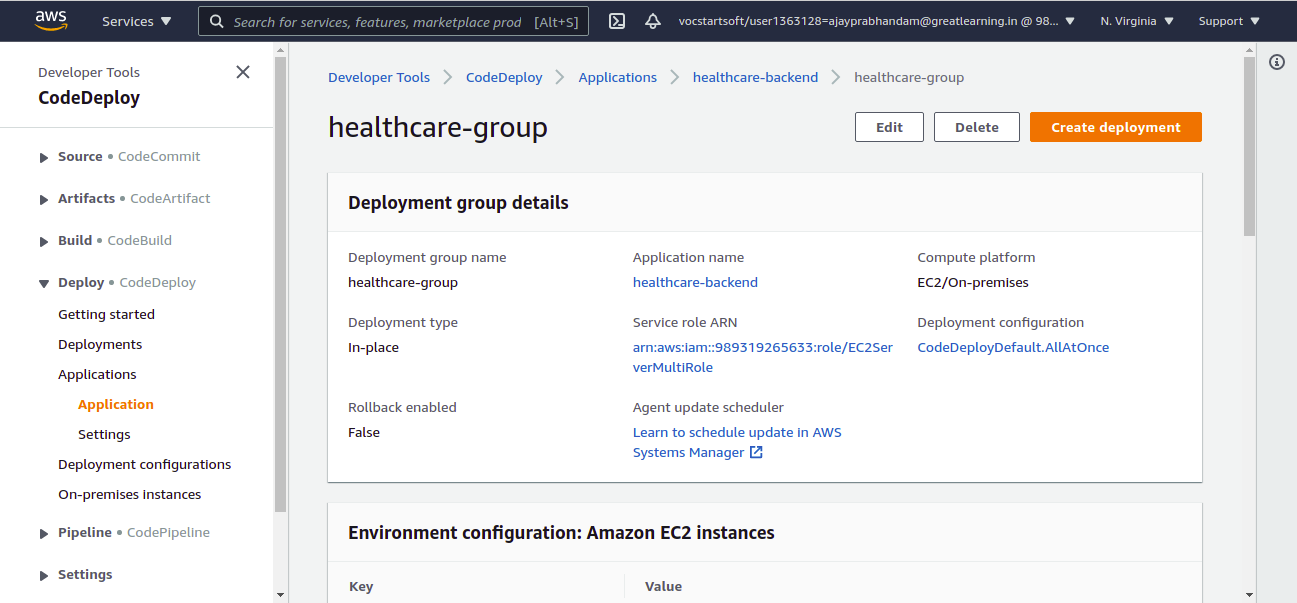

We specify that the deployment needs to pick up the **artifact revision** from an **S3 bucket** as part of the **CodeBuild** stage. We provide the **S3 bucket URI** over here:

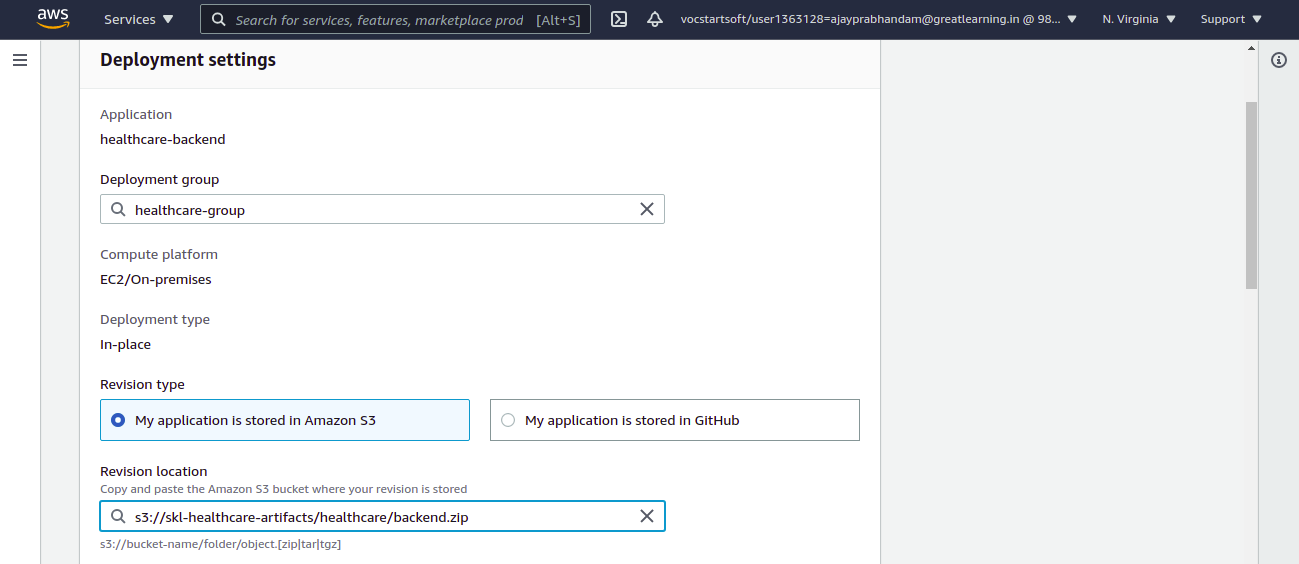

We also specify that the artifact is a ```zip``` archive:

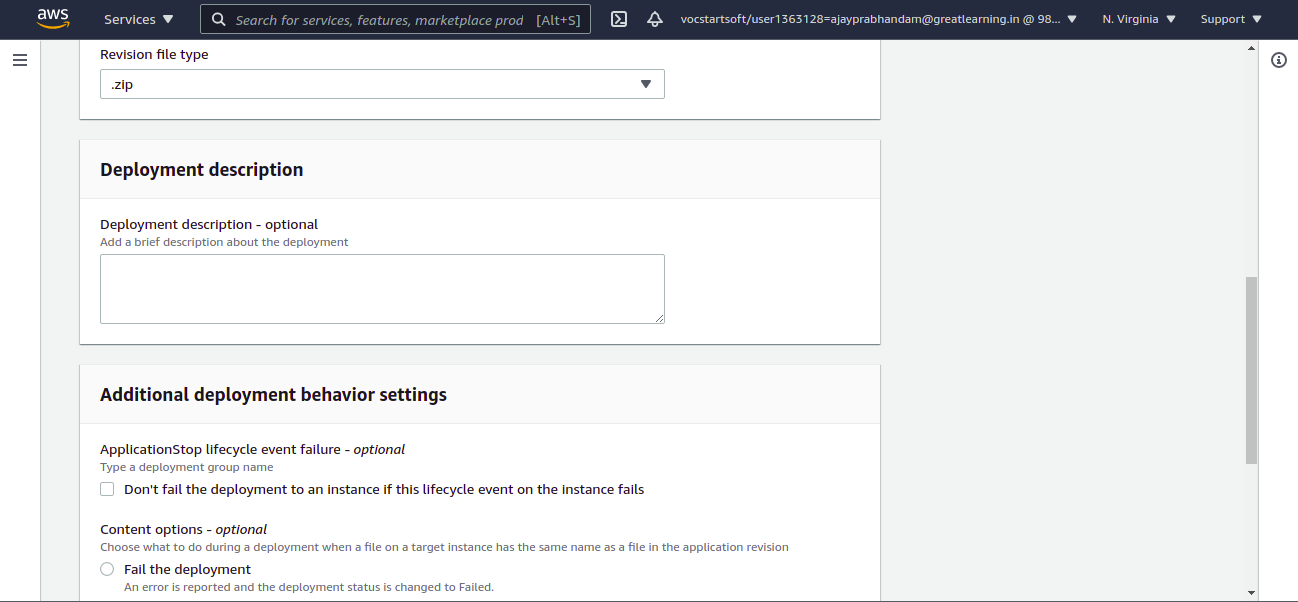

We can retain default values for the rest of the setup, and complete the **Deployment** creation.

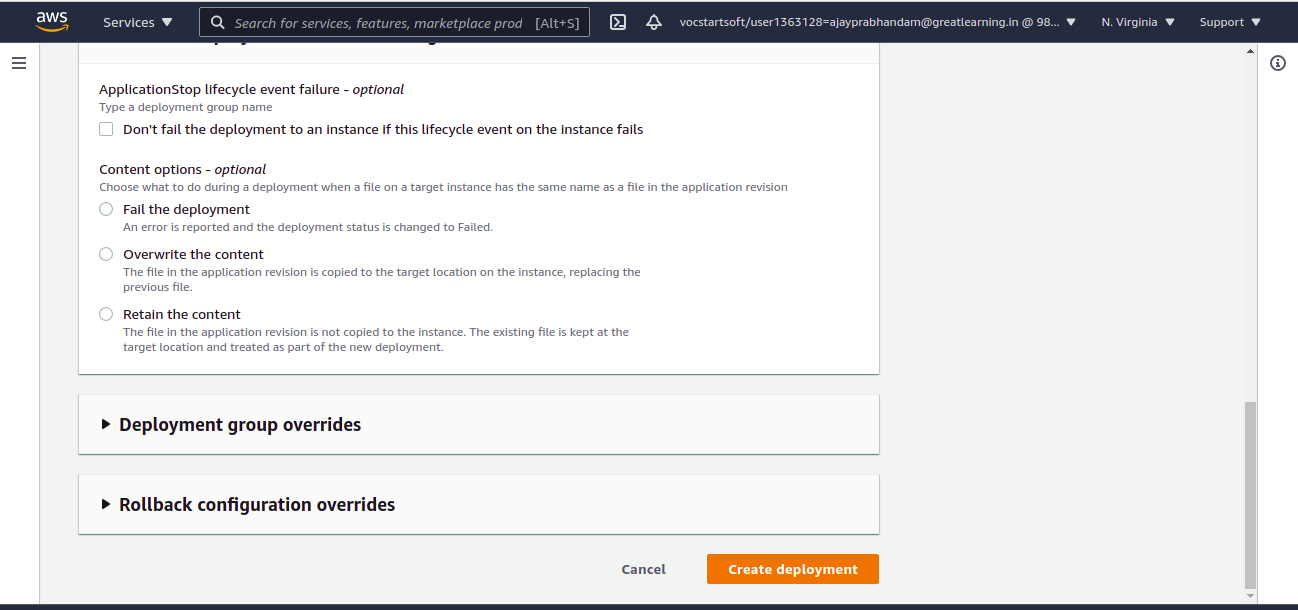

As soon as we click on ```Create Deployment```, we see a status message that it has started.

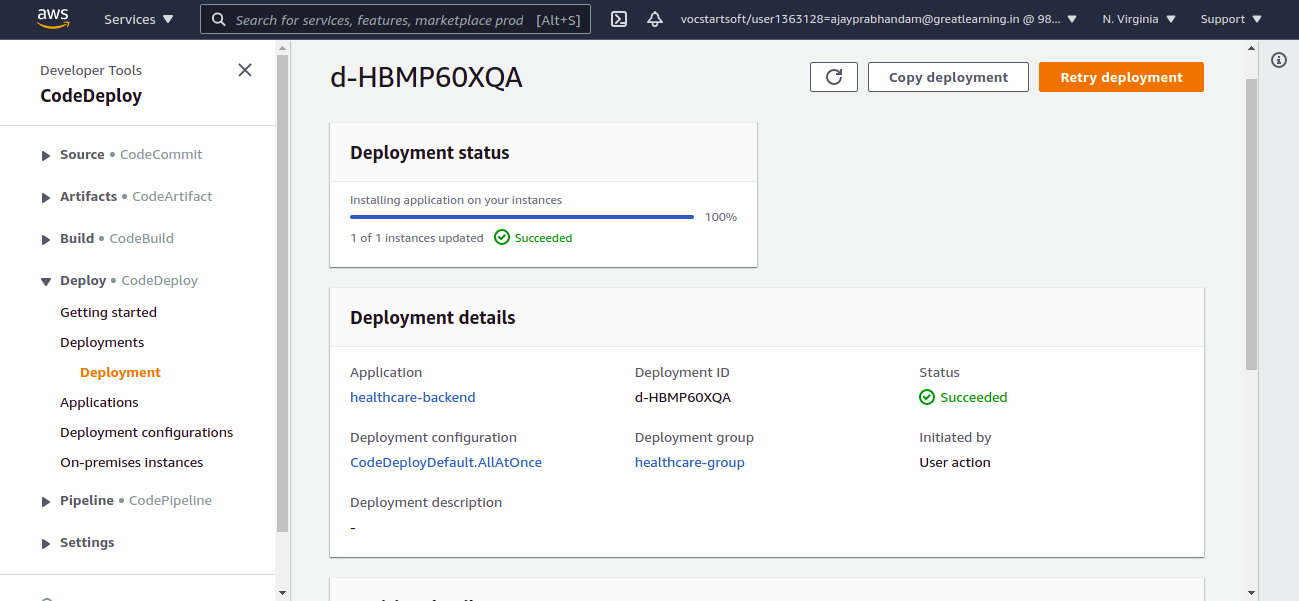

If we scroll down, we get a link saying ```Get Events```:

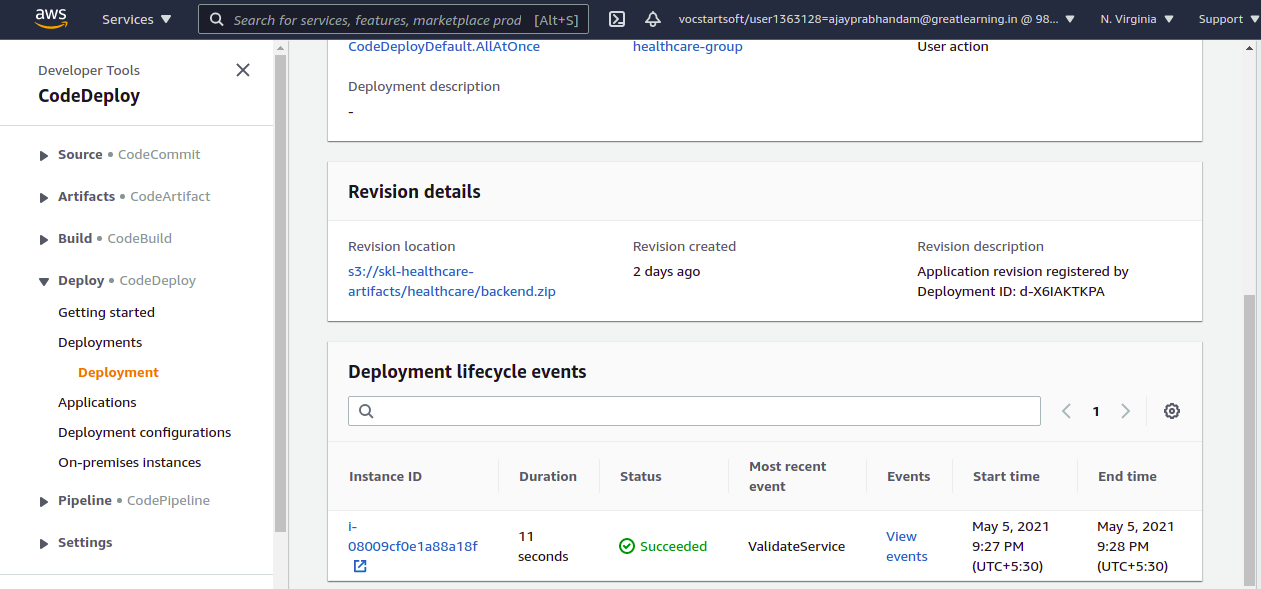

On clicking, it shows events generated during the various stages of deployment. In short, we get a status event corresponding to each **hook** we specifed in the ```appspec.yml```.

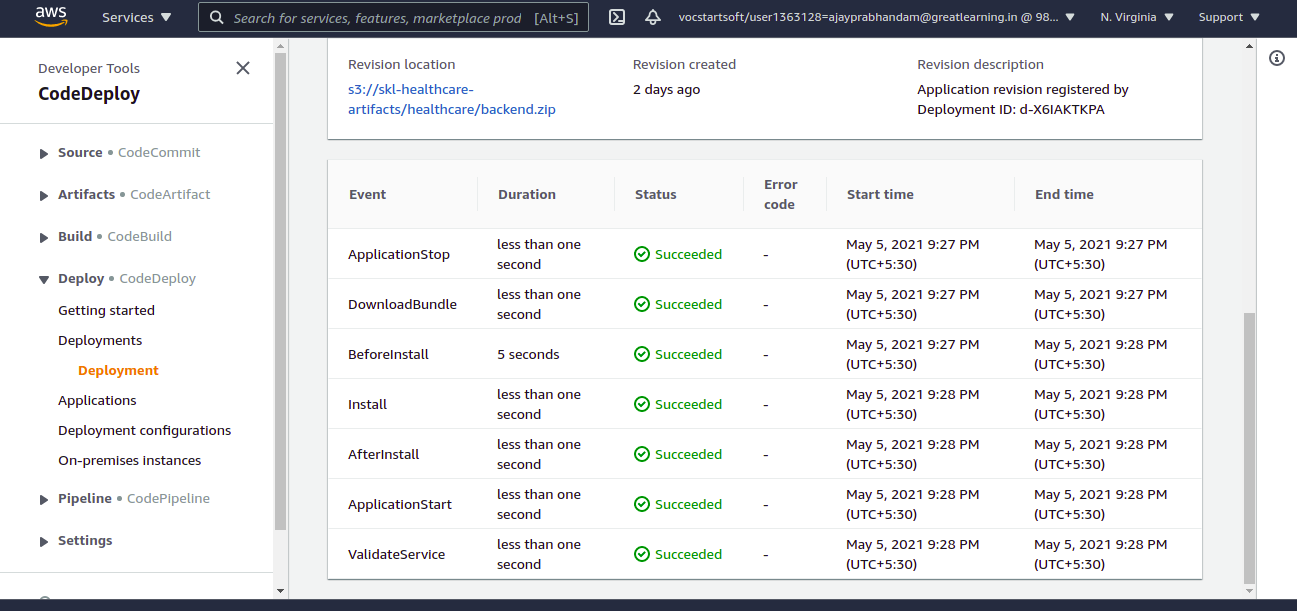

The sequence in which hooks are executed is listed out very neatly here. If any of these hooks fail, we will be alerted.

Note that the first hook to be executed is ```ApplicationStop```. This is because the **CodeDeploy Agent** needs to **terminate** the **previously running artifact revision**, before installing the current one. It directly installs the revision only the very first time it is deployed, but it still performs that check.

# <font color='blue'> Accessing The Healthcare Service </font>

Since the deployment is successful, we can try accessing the application at its REST URI - by passing appropriate query parameters:

```http://ec2-54-145-52-194.compute-1.amazonaws.com:8080/api/raw-data?deviceid=bedside-monitor-001&startdate=2021-05-05&enddate=2021-05-05```

Note that we have replaced the original protocol identifier (```https://```) with (**```http://```**).

You can choose the query parameters as appropriate. You should see output similar to:

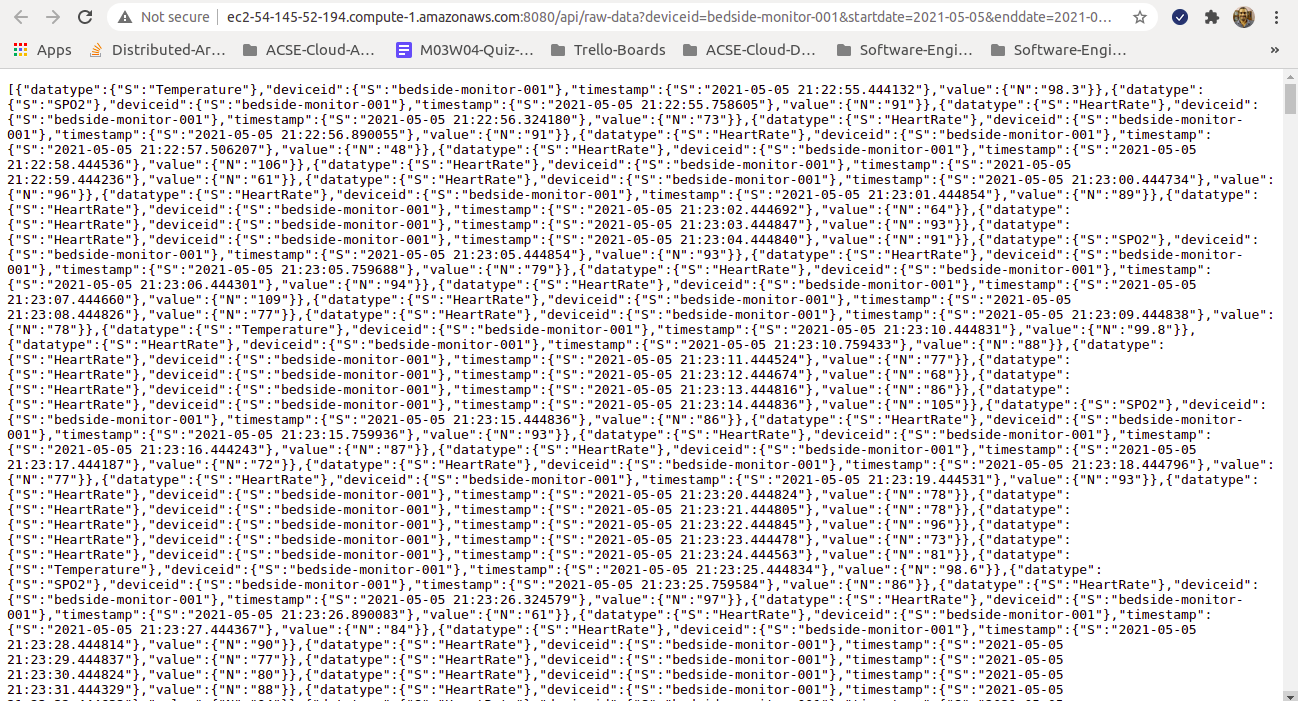

# <font color='blue'> Setting Up A CodePipeline Pipeline </font>

We now link the above stages in sequence, to create an AWS CodePipeline pipeline! The stages, according to sequence, are:

* **CodeCommit**
* **CodeBuild**
* **CodeDeploy**

We go to AWS DevTools, and select ```Pipelines``` on he left frame. On the main page, we click on ```Create Pipeline```:

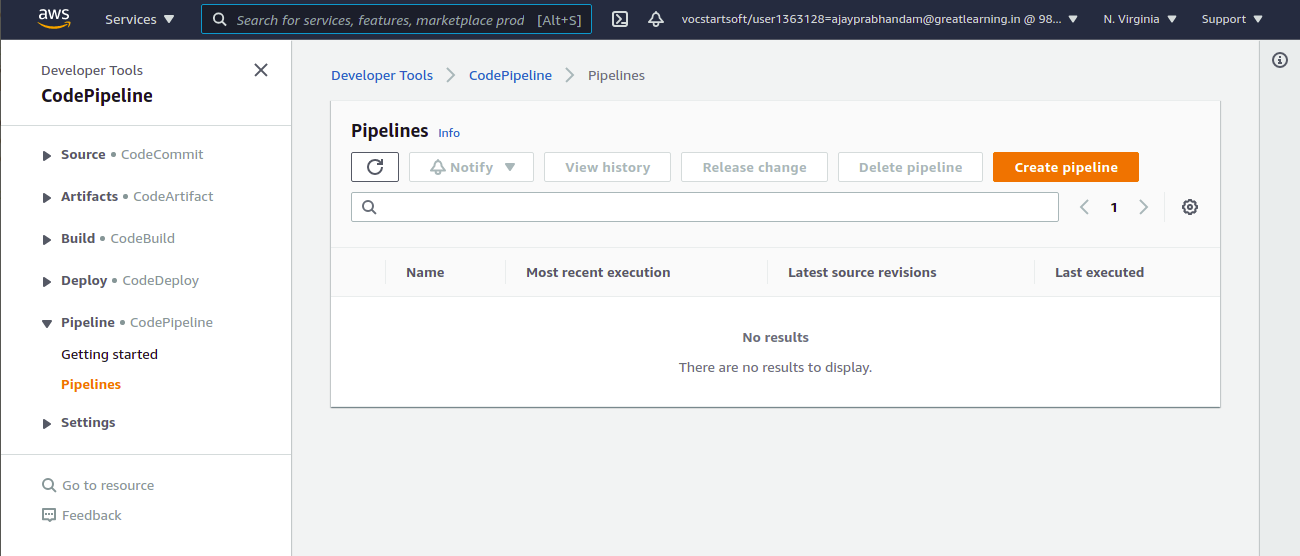

We are familiar with most of the settings in this section, so we go with what we have used in the individual **CodeCommit**, **CodeBuild**, and **CodeDeploy** stages, earlier.

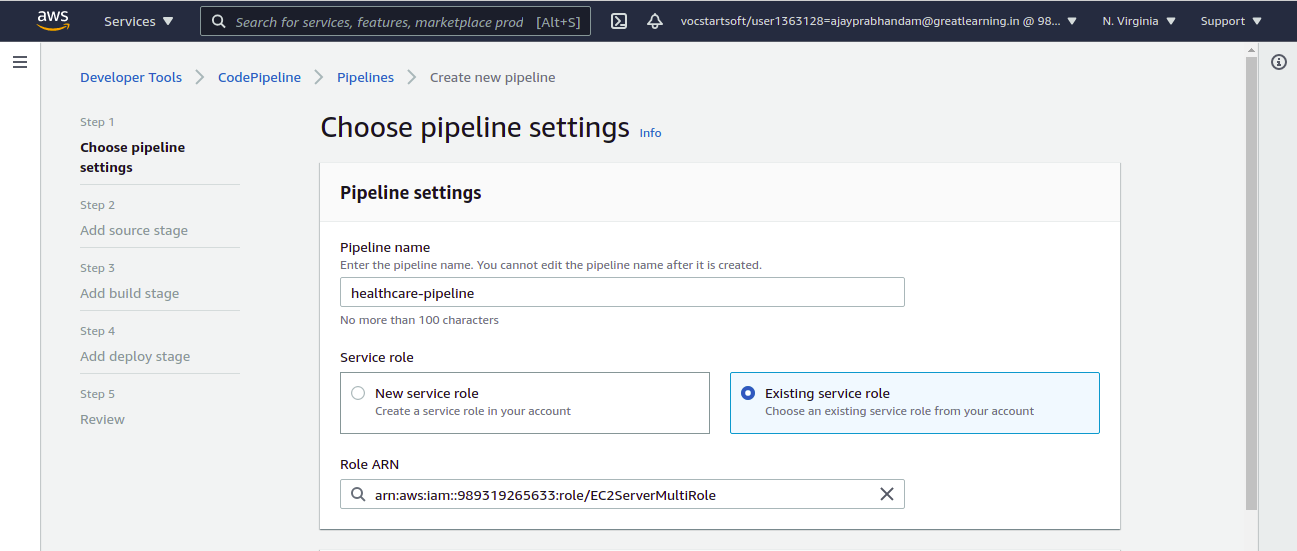

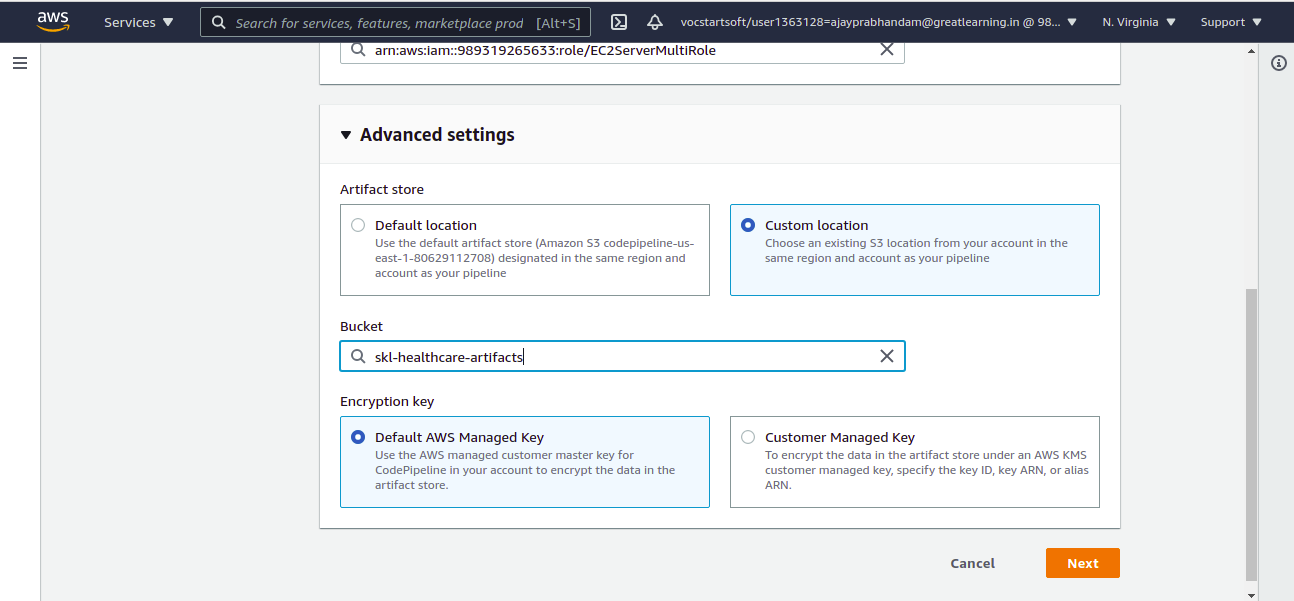

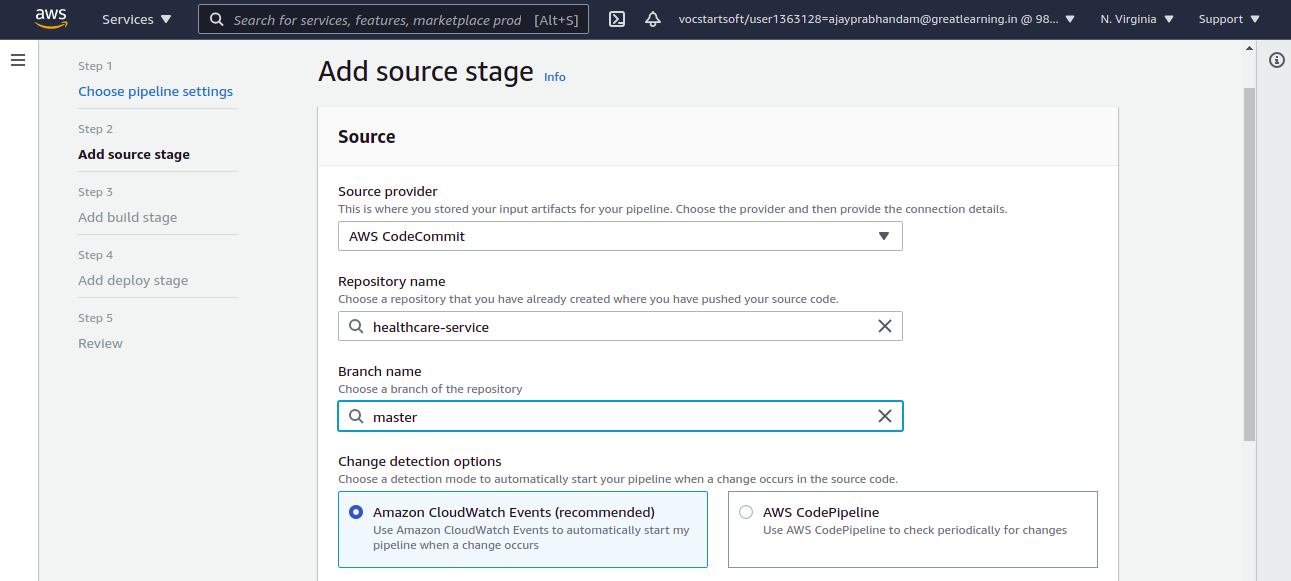

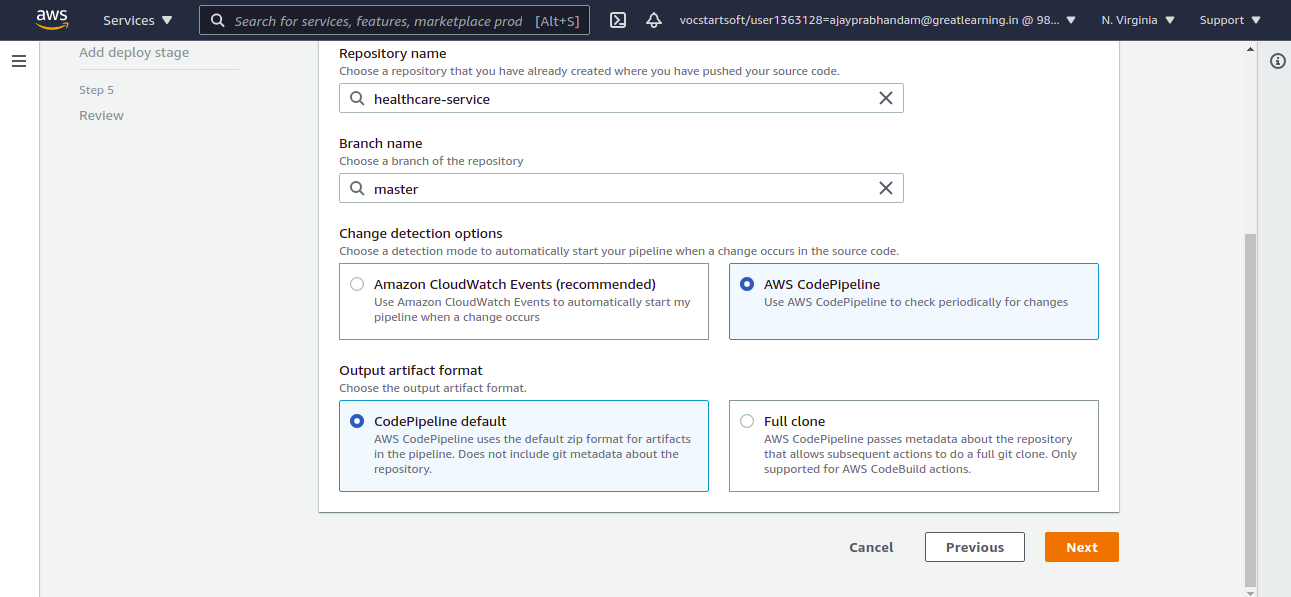

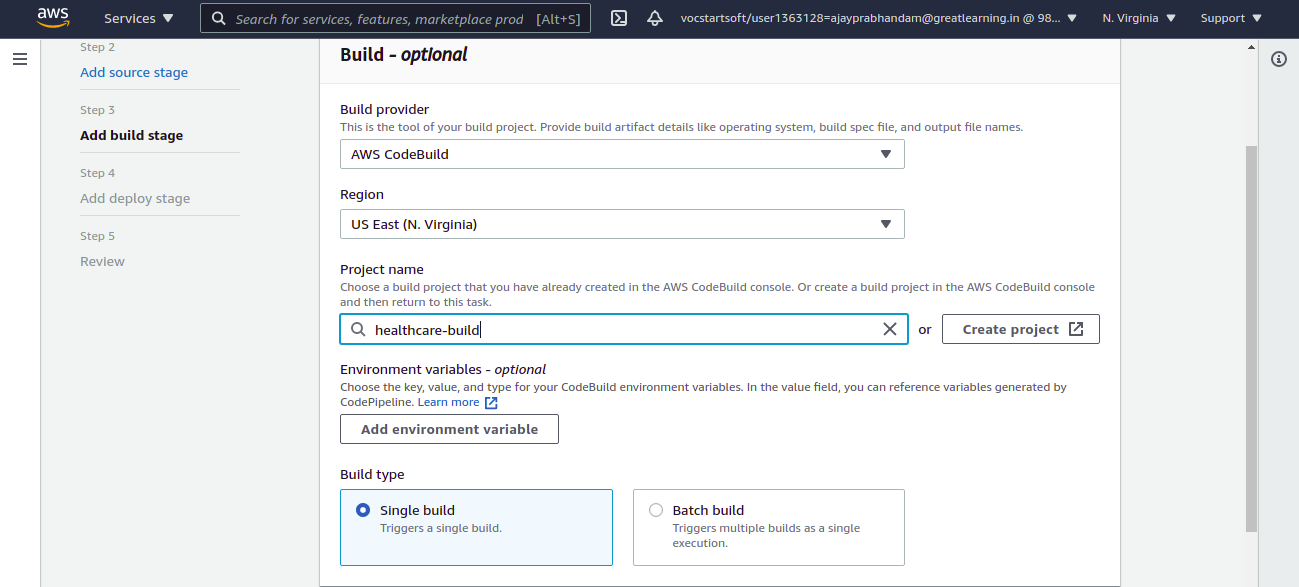

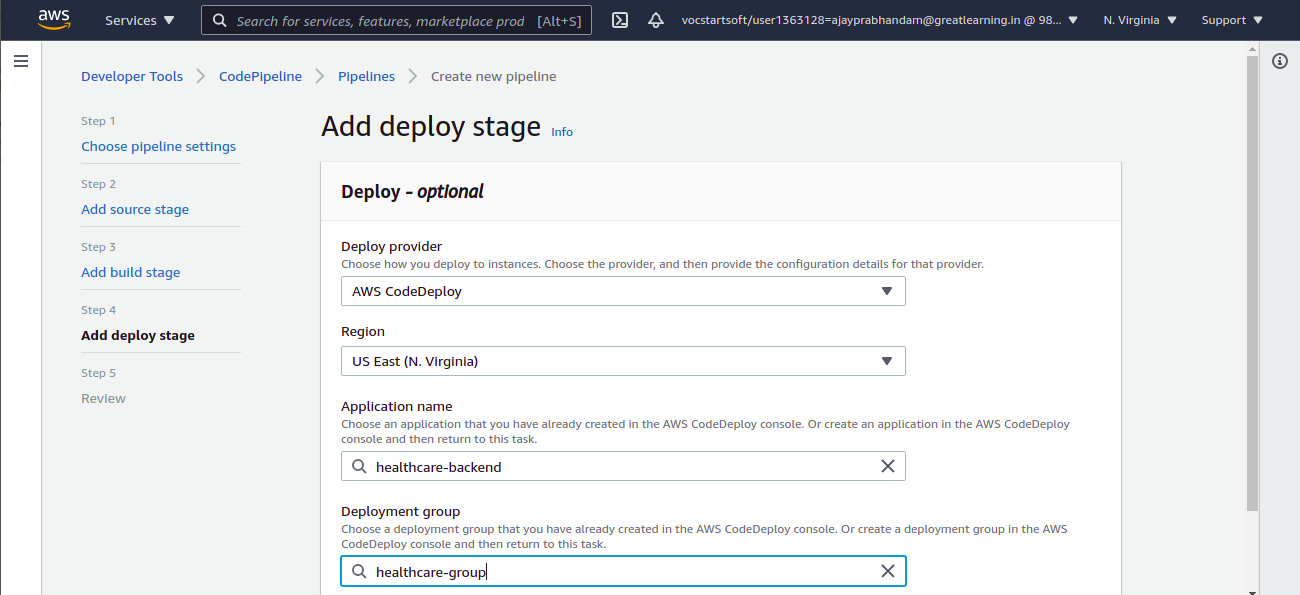

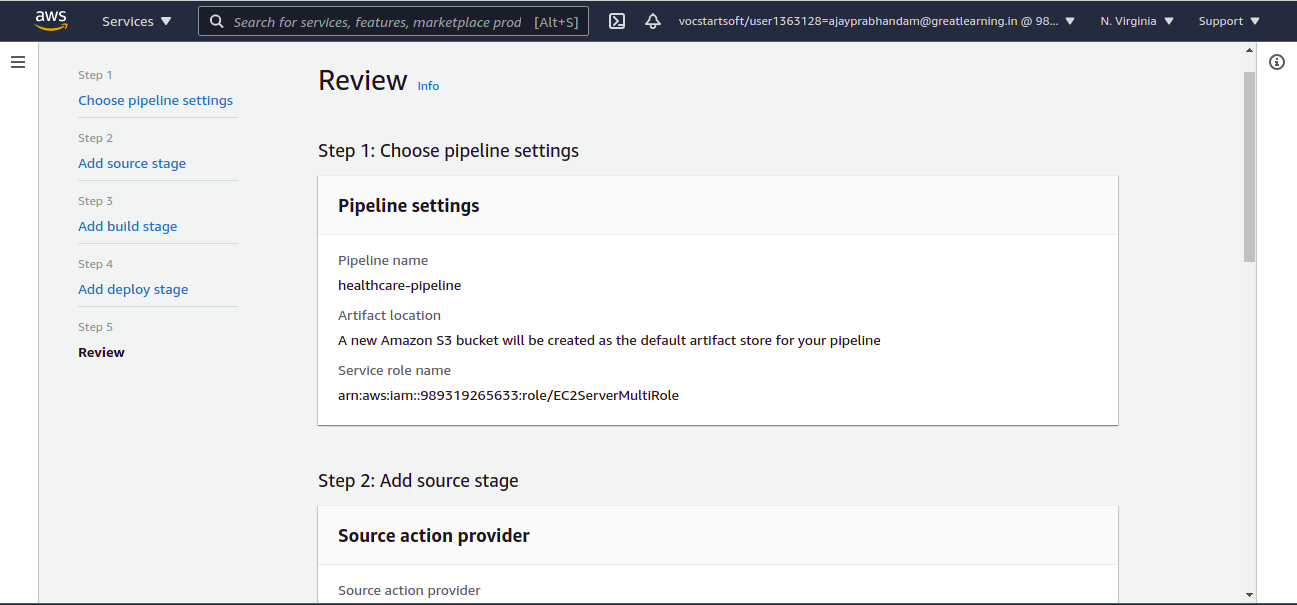

As soon as we click on ```Create Pipeline```, the pipeline is in play. In the future, this pipeline will be activated by every change to the codebase, that is committed to the **CodeCommit** repository.

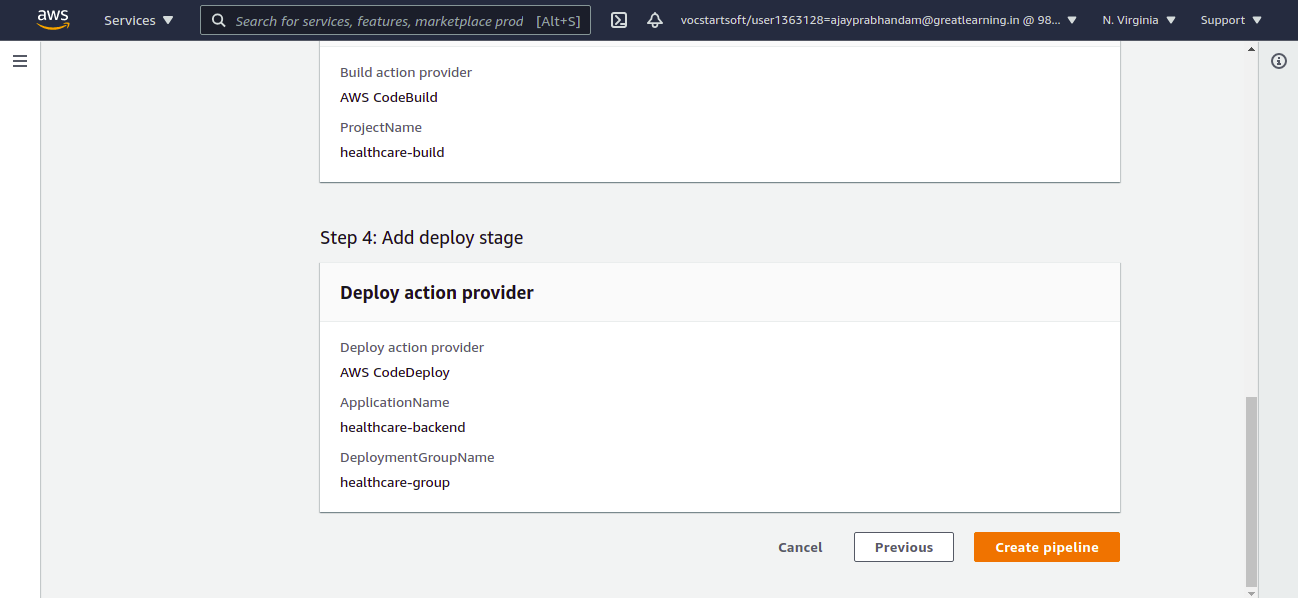

# <font color='blue'> Activating And Running The CodePipeline </font>

The **CodePipeline pipeline** that we just created is automatically activated on a fresh push to the **CodeCommit** repository. Create the ```backend.zip``` codebase archive afresh, and repeat the sequence fo git commands in the local ```healthcare-service``` Git repository.

The following sequence of images illustrates a successful scenario where the entire pipeline executes to completion, ending in the deployment of a fresh artifact revision.

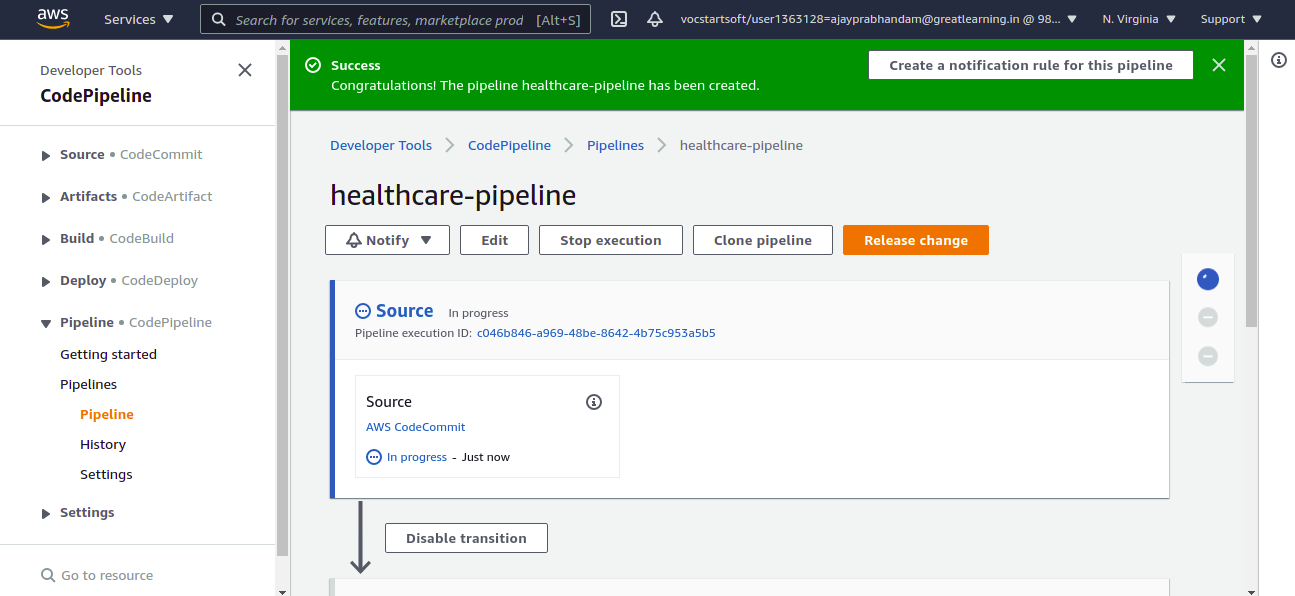

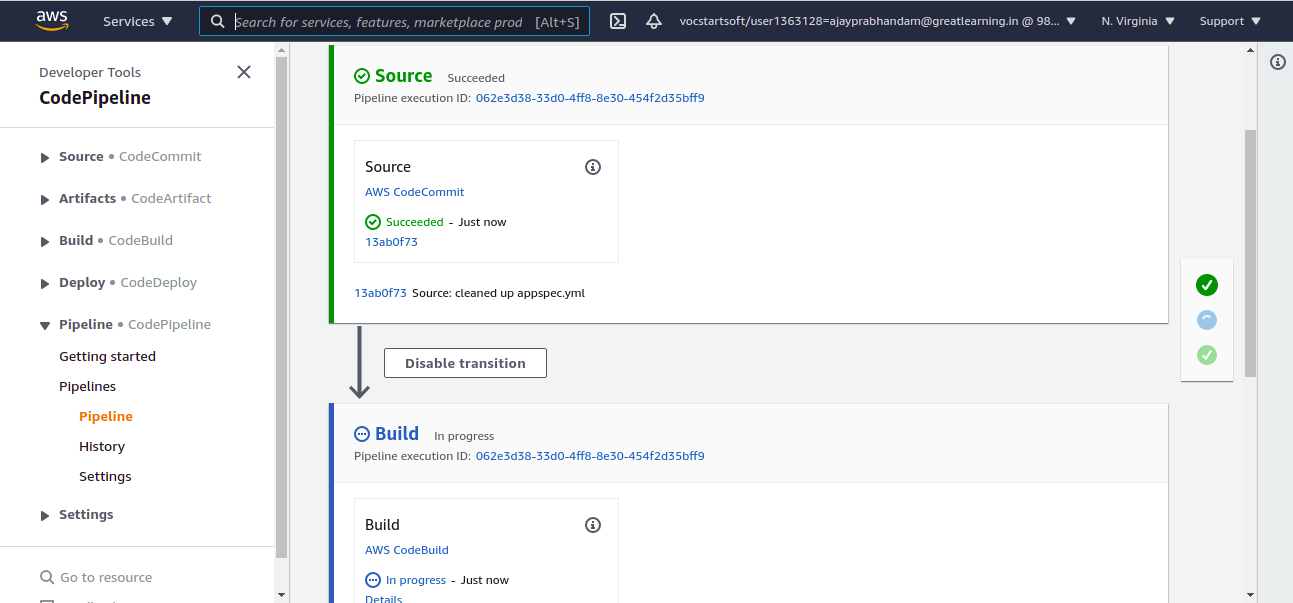

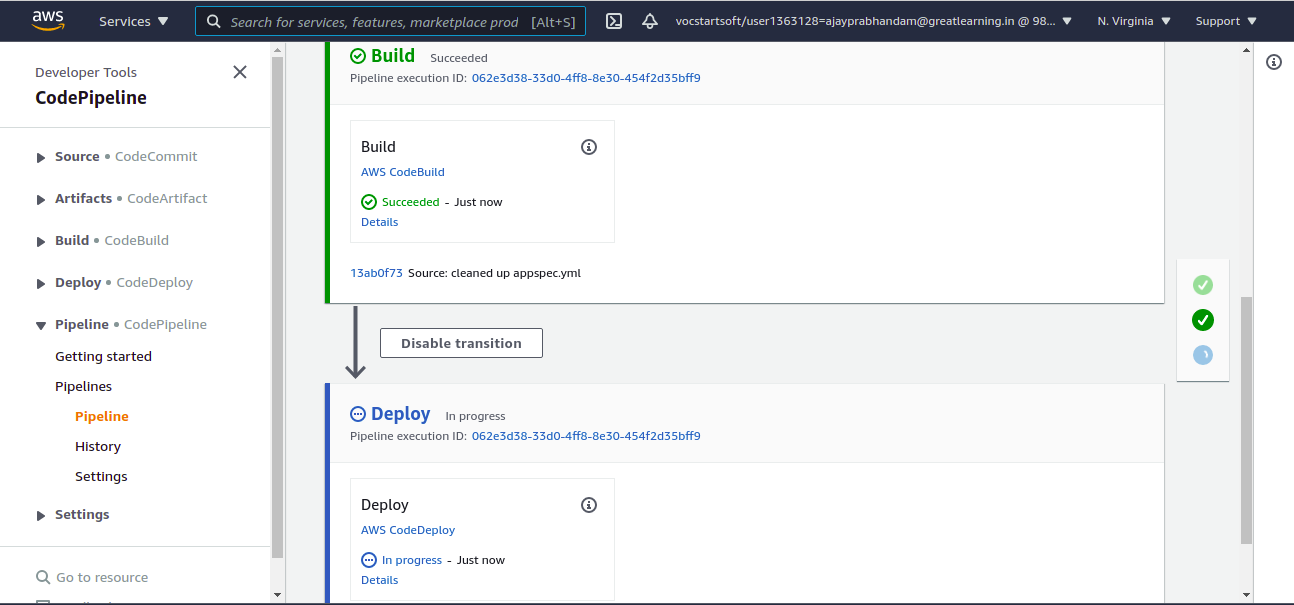

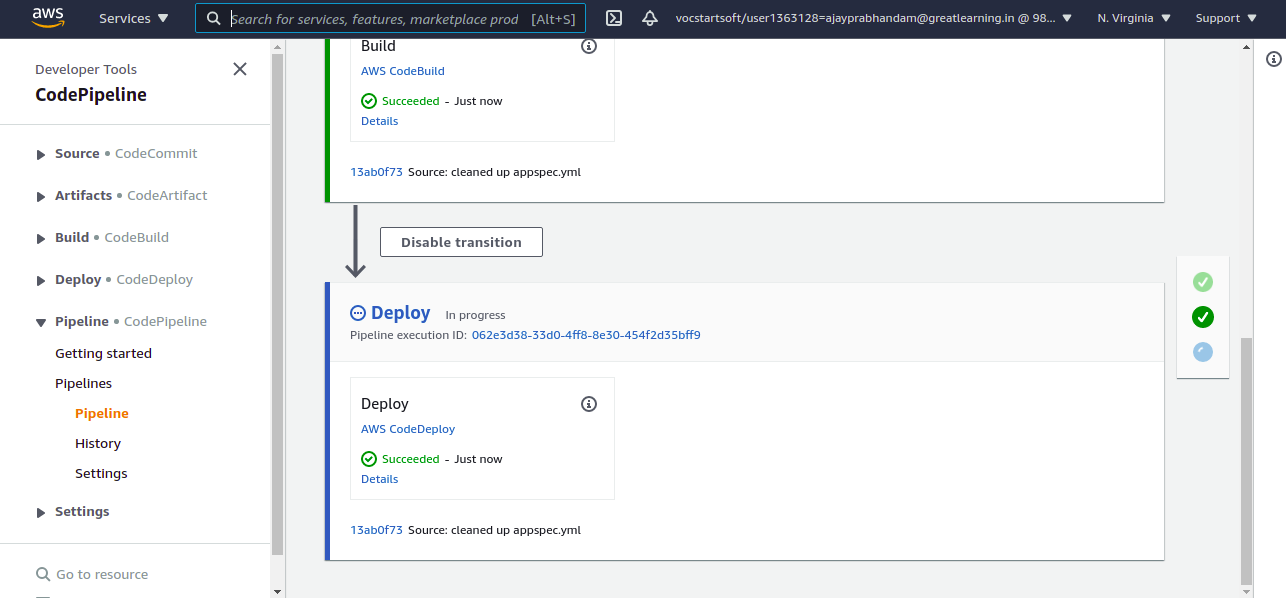

# <font color='blue'> Accessing The Healthcare Service </font>

Now, we can try accessing the public URL of the running EC2 instance, where the application is deployed:

```http://ec2-54-145-52-194.compute-1.amazonaws.com:8080/api/raw-data?deviceid=bedside-monitor-001&startdate=2021-05-05&enddate=2021-05-06```

We can verify that the application is deployed, and can be accessed:

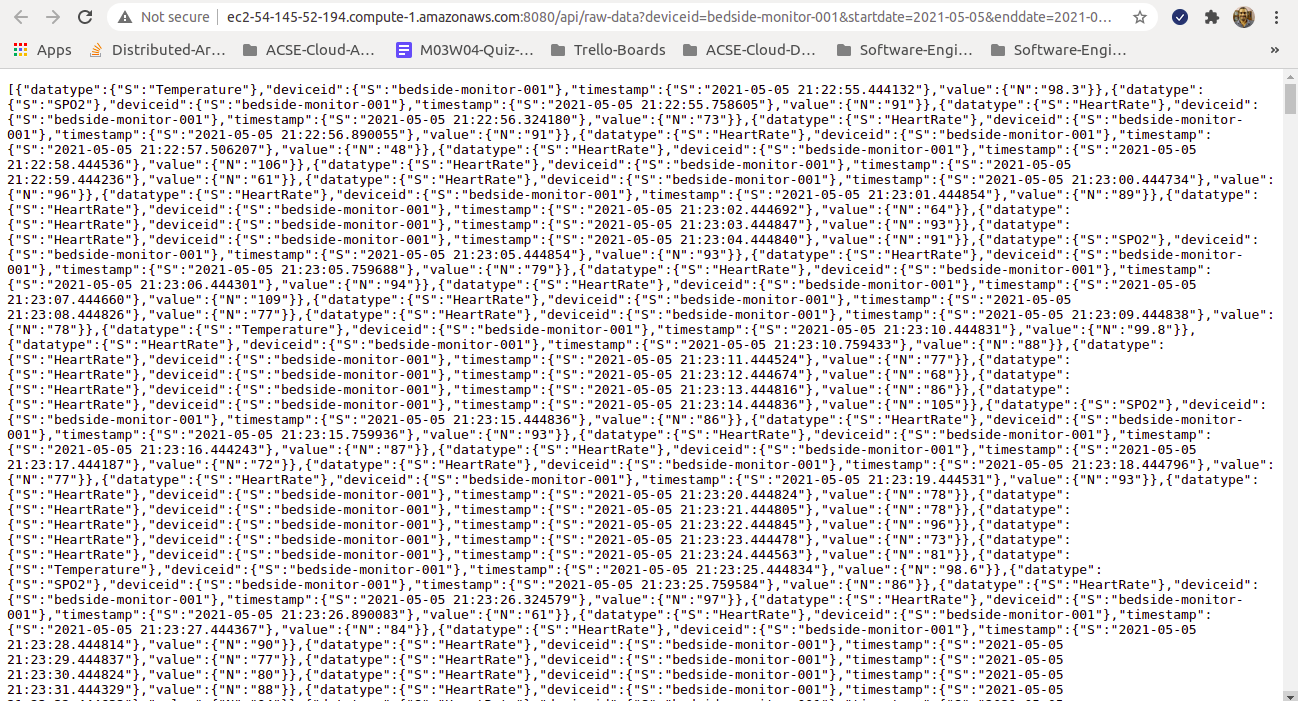